# Exploratory Data Analysis

The dataset comprises sales data from three stores, each selling six different types of products. The analysis aims to uncover patterns, trends, and insights that will assist in accurate future sales prediction, focusing particularly on a forecast for a week in three months. Key aspects explored include sales distribution, promotional impacts, store-specific behavior, seasonal trends, and SKU-level analysis. Recommendations derived from these insights will help refine sales and promotion strategies to optimize future sales outcomes.

### Load libraries

In [480]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np

from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose

### Import Data



I use two datasets for this exercise, based on the ones from the **Sales Forecasting** competition from Kaggle (https://www.kaggle.com/competitions/sales-forecasting-tdt4173/data).

- **beer_train.csv:** This dataset represents historical sales data for various SKUs (products) across different stores. The data is provided on a daily basis and includes information about whether a product was on promotion (via the *isPromo* column) and the sales amount for each SKU (*Sales*).

- **id_store_sku.csv:** This dataset links store IDs to specific SKUs. Each entry represents a product (SKU) sold at a given store on a specific day. The dataset allows for identifying which store and product were involved in each sales transaction, based on the *ts_id* (time series ID).

In [481]:
def load_csv(file_path):
    try:
        data = pd.read_csv(file_path)
        print(f"File '{file_path}' successfully loaded.")
        return data
    except FileNotFoundError:
        print(f"File '{file_path}' not found.")
        return None
    except pd.errors.EmptyDataError:
        print(f"File '{file_path}' is empty.")
        return None
    except pd.errors.ParserError:
        print(f"File '{file_path}' has a CSV format error.")
        return None

In [482]:
beer_data = load_csv( "./beer_train.csv")
beer_data.head()

File './beer_train.csv' successfully loaded.


,Date,ts_id,isPromo,Sales
0,2015-06-15,0,0.0,0.10
1,2015-06-15,1,0.0,0.35
2,2015-06-15,2,1.0,0.60
3,2015-06-15,3,1.0,0.35
4,2015-06-15,4,0.0,0.15


In [483]:
store_sku_data = load_csv( "./id_store_sku.csv")
store_sku_data.head()

File './id_store_sku.csv' successfully loaded.


,ts_id,Store,SKU
0,0,3301,"_Baltika №0 Can 0,45"
1,1,3301,"_Baltika №3 Can 0,45"
2,2,3301,"_Baltika №7 Can 0,45"
3,3,3301,"_Baltika №7 Bottle 0,47"
4,4,3301,"_Baltika №9 Can 0,45"


In [484]:
df = pd.merge(beer_data, store_sku_data, on='ts_id')
df['date'] = pd.to_datetime(df['Date'])
df = df.drop(columns=['ts_id', 'Date'])

print(df.head())

   isPromo  Sales Store                      SKU       date
0      0.0   0.10  3301     _Baltika №0 Can 0,45 2015-06-15
1      0.0   0.35  3301     _Baltika №3 Can 0,45 2015-06-15
2      1.0   0.60  3301     _Baltika №7 Can 0,45 2015-06-15
3      1.0   0.35  3301  _Baltika №7 Bottle 0,47 2015-06-15
4      0.0   0.15  3301     _Baltika №9 Can 0,45 2015-06-15


In [490]:
def print_all_sku_names(data):
    sku_names = data['SKU'].unique()
    for name in sku_names:
        print(name)

print_all_sku_names(df)

_Baltika №0 Can 0,45
_Baltika №3 Can 0,45
_Baltika №7 Can 0,45
_Baltika №7 Bottle 0,47
_Baltika №9 Can 0,45
_Don PET 1,42


In [491]:
def simplify_sku_name(sku):
    sku = re.sub(r'(\d{1,2},\d{1,2})', '', sku)
    sku = sku.lstrip('_')
    sku = sku.strip()
    return sku

df['SKU'] = df['SKU'].apply(simplify_sku_name)
simplified_skus = df['SKU'].unique()
for name in simplified_skus:
    print(name)

Baltika №0 Can
Baltika №3 Can
Baltika №7 Can
Baltika №7 Bottle
Baltika №9 Can
Don PET


In [492]:
df

,isPromo,Sales,Store,SKU,date
0,0.0,0.100,3301,Baltika №0 Can,2015-06-15
1,0.0,0.350,3301,Baltika №3 Can,2015-06-15
2,1.0,0.600,3301,Baltika №7 Can,2015-06-15
3,1.0,0.350,3301,Baltika №7 Bottle,2015-06-15
4,0.0,0.150,3301,Baltika №9 Can,2015-06-15
...,...,...,...,...,...
13153,0.0,0.000,5941,Baltika №3 Can,2017-06-14
13154,0.0,0.000,5941,Baltika №7 Can,2017-06-14
13155,1.0,0.658,5941,Baltika №7 Bottle,2017-06-14
13156,0.0,0.090,5941,Baltika №9 Can,2017-06-14


### Part 1: Data quality
Checking the quality of the data provided and cleaning it if necessary.

In [493]:
duplicate_rows = df[df.duplicated(keep=False)]
print("Duplicate rows:\n", duplicate_rows)

Duplicate rows:
 Empty DataFrame
Columns: [isPromo, Sales, Store, SKU, date]
Index: []


No exact duplicates exist in the dataset, there is no need to drop duplicates.

In [494]:
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_percentage_rounded = missing_percentage.round().astype(str) + '%'
missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage_rounded})

print("Missing data overview:\n", missing_data)

Missing data overview:
          Missing Values Percentage
isPromo               0       0.0%
Sales               657       5.0%
Store                 0       0.0%
SKU                   0       0.0%
date                  0       0.0%


Only Sales have missing values.

In [495]:
df['is_missing'] = df['Sales'].isnull()
missing_by_store = df.groupby(['Store', 'is_missing']).size().unstack()
missing_by_sku = df.groupby(['SKU', 'is_missing']).size().unstack()

print("Missing data by store:\n", missing_by_store)
print("\nMissing data by SKU:\n", missing_by_sku)

Missing data by store:
 is_missing  False  True 
Store                   
3301         4166    220
3336         4168    218
5941         4167    219

Missing data by SKU:
 is_missing         False  True 
SKU                            
Baltika №0 Can      2065    128
Baltika №3 Can      2078    115
Baltika №7 Bottle   2087    106
Baltika №7 Can      2108     85
Baltika №9 Can      2080    113
Don PET             2083    110


In [496]:
missing_vs_promotion = df.groupby(['isPromo', 'is_missing']).size().unstack()
print("\nMissing data by promotion status:\n", missing_vs_promotion)


Missing data by promotion status:
 is_missing  False  True 
isPromo                 
0.0          9456    516
1.0          3000    139
2.0            45      2


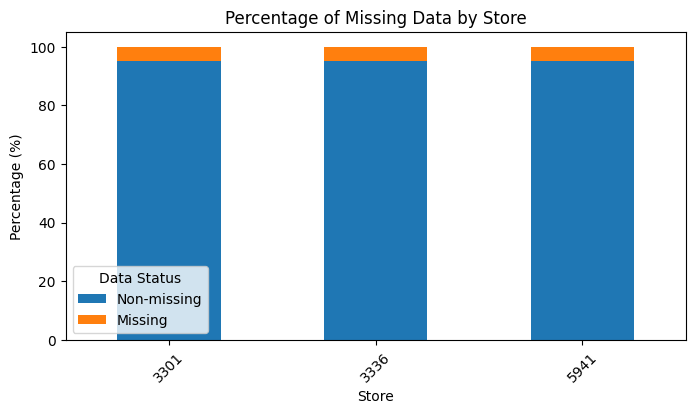

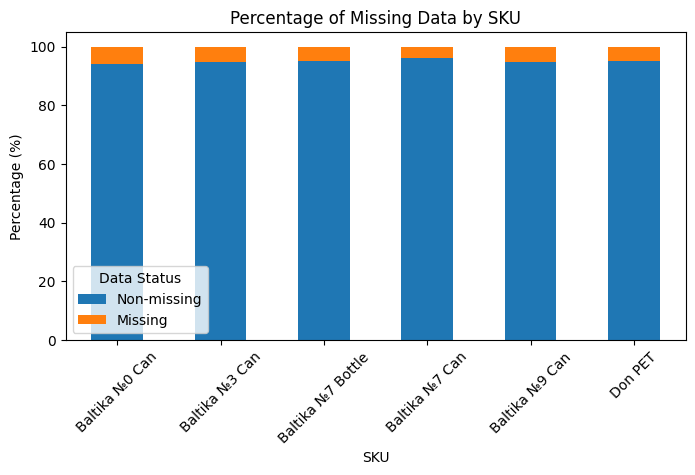

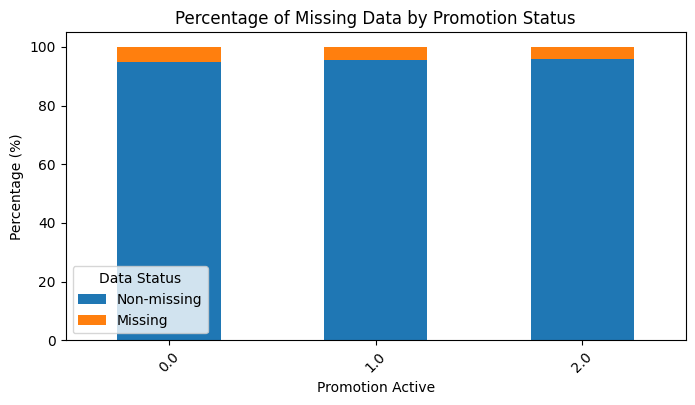

In [497]:
missing_by_store_pct = missing_by_store.div(missing_by_store.sum(axis=1), axis=0) * 100
missing_by_sku_pct = missing_by_sku.div(missing_by_sku.sum(axis=1), axis=0) * 100
missing_vs_promotion_pct = missing_vs_promotion.div(missing_vs_promotion.sum(axis=1), axis=0) * 100

missing_by_store_pct.plot(kind='bar', stacked=True, figsize=(8, 4))
plt.title('Percentage of Missing Data by Store')
plt.xlabel('Store')
plt.ylabel('Percentage (%)')
plt.legend(['Non-missing', 'Missing'], title='Data Status')
plt.xticks(rotation=45)
plt.show()

missing_by_sku_pct.plot(kind='bar', stacked=True, figsize=(8, 4))
plt.title('Percentage of Missing Data by SKU')
plt.xlabel('SKU')
plt.ylabel('Percentage (%)')
plt.legend(['Non-missing', 'Missing'], title='Data Status')
plt.xticks(rotation=45)
plt.show()

missing_vs_promotion_pct.plot(kind='bar', stacked=True, figsize=(8, 4))
plt.title('Percentage of Missing Data by Promotion Status')
plt.xlabel('Promotion Active')
plt.ylabel('Percentage (%)')
plt.legend(['Non-missing', 'Missing'], title='Data Status')
plt.xticks(rotation=45)
plt.show()

The analysis indicates that missing data is distributed uniformly across different SKUs, stores, and promotion statuses, with consistent percentages observed in each category. This pattern suggests that the missing data issue is a general characteristic of the entire dataset, rather than being concentrated in specific SKUs, stores, or promotional periods.

In [498]:
def fill_missing_sales(df: pd.DataFrame):
    for (store, sku), group in df.groupby(['Store', 'SKU']):
        df.loc[group.index, 'Sales'] = group['Sales'].bfill().fillna(group['Sales'].mean())
    return df

df = df.drop(columns=['is_missing'])
df = fill_missing_sales(df)

In [499]:
df

,isPromo,Sales,Store,SKU,date
0,0.0,0.100,3301,Baltika №0 Can,2015-06-15
1,0.0,0.350,3301,Baltika №3 Can,2015-06-15
2,1.0,0.600,3301,Baltika №7 Can,2015-06-15
3,1.0,0.350,3301,Baltika №7 Bottle,2015-06-15
4,0.0,0.150,3301,Baltika №9 Can,2015-06-15
...,...,...,...,...,...
13153,0.0,0.000,5941,Baltika №3 Can,2017-06-14
13154,0.0,0.000,5941,Baltika №7 Can,2017-06-14
13155,1.0,0.658,5941,Baltika №7 Bottle,2017-06-14
13156,0.0,0.090,5941,Baltika №9 Can,2017-06-14


The missing value is filled using the next available value in the series. If any missing values remain after backfilling, they are filled with the mean of the sales values for that particular group (Store and SKU).

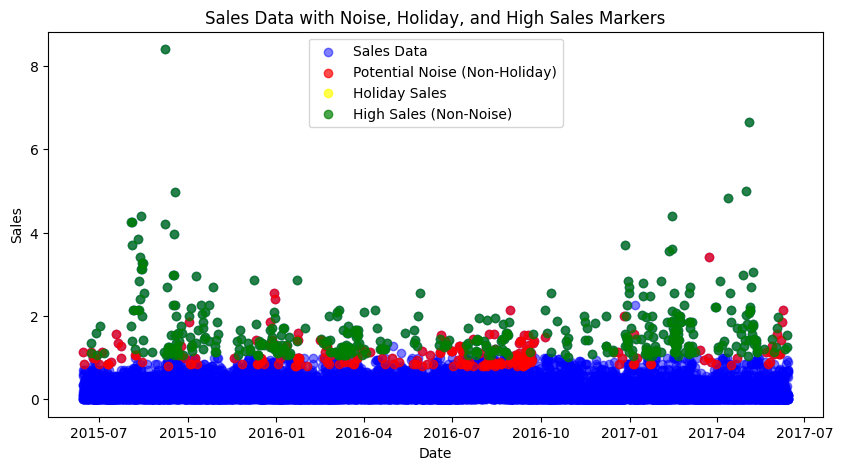

In [500]:
russian_holidays = pd.to_datetime([
    '2015-01-01', '2015-01-02', '2015-01-07', '2015-02-23', '2015-03-08',
    '2015-05-01', '2015-05-09', '2015-06-12', '2015-11-04',
    '2016-01-01', '2016-01-02', '2016-01-07', '2016-02-23', '2016-03-08',
    '2016-05-01', '2016-05-09', '2016-06-12', '2016-11-04',
    '2017-01-01', '2017-01-02', '2017-01-07', '2017-02-23', '2017-03-08',
    '2017-05-01', '2017-05-09', '2017-06-12', '2017-11-04'
])

zscore_threshold = 2.5  # Z-score threshold for detecting outliers
iqr_multiplier = 1.5    # Multiplier for IQR bounds

df['Z_score'] = (df['Sales'] - df['Sales'].mean()) / df['Sales'].std()
outliers_zscore = df[np.abs(df['Z_score']) > zscore_threshold]

Q1 = df['Sales'].quantile(0.25)
Q3 = df['Sales'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - iqr_multiplier * IQR
upper_bound = Q3 + iqr_multiplier * IQR
outliers_iqr = df[(df['Sales'] < lower_bound) | (df['Sales'] > upper_bound)]

outliers = pd.concat([outliers_zscore, outliers_iqr]).drop_duplicates()
outliers['is_holiday'] = outliers['date'].isin(russian_holidays)
outliers['is_promotion'] = outliers['isPromo'] > 0
outliers['is_noise'] = ~outliers['is_holiday'] & ~outliers['is_promotion']
potential_noise = outliers[outliers['is_noise']]

threshold = 1
non_noise_outliers = df[(df['Sales'] > threshold) & ~df.index.isin(potential_noise.index) & (df['isPromo'] > 0)]
holiday_outliers = potential_noise[potential_noise['is_holiday']]
non_holiday_outliers = potential_noise[~potential_noise['is_holiday']]

plt.figure(figsize=(10, 5))
plt.scatter(df['date'], df['Sales'], alpha=0.5, label='Sales Data', color='blue')
plt.scatter(non_holiday_outliers['date'], non_holiday_outliers['Sales'], color='red', label='Potential Noise (Non-Holiday)', alpha=0.7)
plt.scatter(holiday_outliers['date'], holiday_outliers['Sales'], color='yellow', label='Holiday Sales', alpha=0.7)
plt.scatter(non_noise_outliers['date'], non_noise_outliers['Sales'], color='green', label='High Sales (Non-Noise)', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Data with Noise, Holiday, and High Sales Markers')
plt.legend()
plt.show()

The plot shows a clear distinction between potential noise (red points) and high sales that are not flagged as noise (green points).
The red points represent potential noise on non-holiday dates,
green points represent high sales during promotional periods that are not considered noise.

In [501]:
df = df.drop(columns=['Z_score'])
df

,isPromo,Sales,Store,SKU,date
0,0.0,0.100,3301,Baltika №0 Can,2015-06-15
1,0.0,0.350,3301,Baltika №3 Can,2015-06-15
2,1.0,0.600,3301,Baltika №7 Can,2015-06-15
3,1.0,0.350,3301,Baltika №7 Bottle,2015-06-15
4,0.0,0.150,3301,Baltika №9 Can,2015-06-15
...,...,...,...,...,...
13153,0.0,0.000,5941,Baltika №3 Can,2017-06-14
13154,0.0,0.000,5941,Baltika №7 Can,2017-06-14
13155,1.0,0.658,5941,Baltika №7 Bottle,2017-06-14
13156,0.0,0.090,5941,Baltika №9 Can,2017-06-14


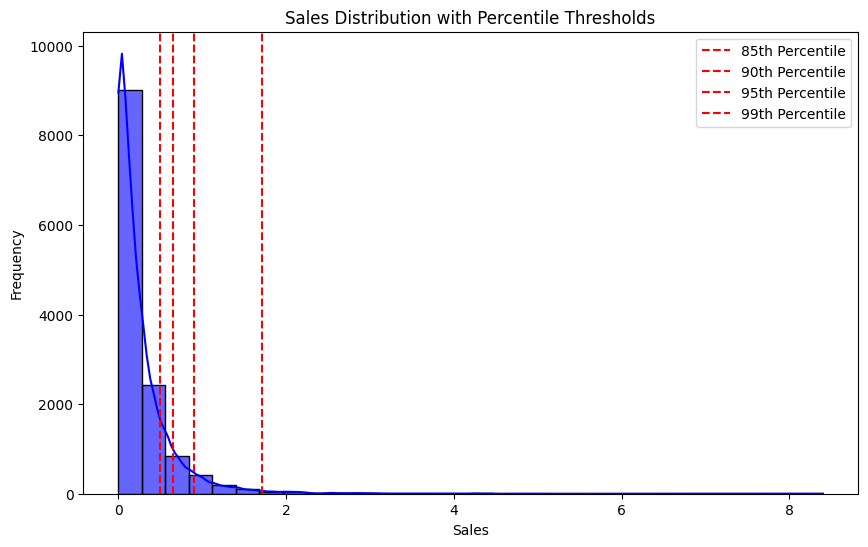

In [502]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Sales'], bins=30, kde=True, color='blue', alpha=0.6)

percentiles = [85, 90, 95, 99]
for p in percentiles:
    threshold = np.percentile(df['Sales'], p)
    plt.axvline(threshold, color='red', linestyle='--', label=f'{p}th Percentile')

plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.title('Sales Distribution with Percentile Thresholds')
plt.legend()
plt.show()

The histogram plot displays the distribution of sales data, which is heavily right-skewed.

Most of the sales values cluster near the lower end, with a large number of sales values around 0 to 0.5. This suggests a high frequency of low sales amounts and relatively few high-value sales events.

The extreme sales values are associated with either promotions or noise.

In [503]:
non_promo_data = df[df['isPromo'] == 0.0]
Q1 = non_promo_data['Sales'].quantile(0.25)
Q3 = non_promo_data['Sales'].quantile(0.75)
IQR = Q3 - Q1

iqr_multiplier = 1.5
lower_bound = Q1 - iqr_multiplier * IQR
upper_bound = Q3 + iqr_multiplier * IQR

max_non_outlier_value = non_promo_data[non_promo_data['Sales'] <= upper_bound]['Sales'].max()

df.loc[
    (df['isPromo'] == 0.0) & (df['Sales'] > upper_bound),
    'Sales'
] = max_non_outlier_value

print(f"Non-promotional outliers capped at {max_non_outlier_value}")

Non-promotional outliers capped at 0.6


### Part 2: Data Exploration

#### Data Overview

Check Data Types and Summary Statistics

In [504]:
print("\nFirst few rows of the DataFrame:")
print(df.head())
print("Basic Information:")
print(df.info())
print("\nSummary Statistics:")
print(df.describe())

categorical_cols = df.select_dtypes(include=['object', 'category']).columns
numerical_cols = df.select_dtypes(include=['number']).columns
print("Categorical Variables:", categorical_cols)
print("Numerical Variables:", numerical_cols)


First few rows of the DataFrame:
   isPromo  Sales Store                SKU       date
0      0.0   0.10  3301     Baltika №0 Can 2015-06-15
1      0.0   0.35  3301     Baltika №3 Can 2015-06-15
2      1.0   0.60  3301     Baltika №7 Can 2015-06-15
3      1.0   0.35  3301  Baltika №7 Bottle 2015-06-15
4      0.0   0.15  3301     Baltika №9 Can 2015-06-15
Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13158 entries, 0 to 13157
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   isPromo  13158 non-null  float64       
 1   Sales    13158 non-null  float64       
 2   Store    13158 non-null  object        
 3   SKU      13158 non-null  object        
 4   date     13158 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 514.1+ KB
None

Summary Statistics:
            isPromo         Sales                           date
count  13158.000000  13158.000000   

The data consists of 13,158 rows and 6 columns, including both numeric and categorical variables, as well as a date column.

The columns include isPromo (promotion status as a numeric indicator), Sales (sales figures), Store (identifier for store locations), SKU (product identifiers) and date.

#### Target Value

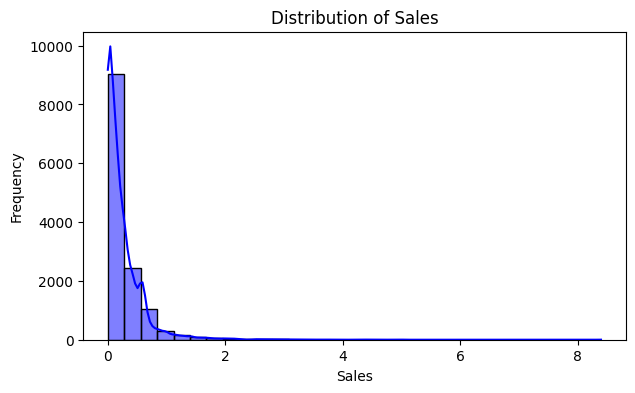

In [505]:
plt.figure(figsize=(7, 4))
sns.histplot(df['Sales'], bins=30, kde=True, color='blue')
plt.title('Distribution of Sales')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()

The histogram plot displays the distribution of sales data, which is heavily right-skewed.

#### Analysis of Numerical Variables

Understand the distribution of demand with and without promotions.

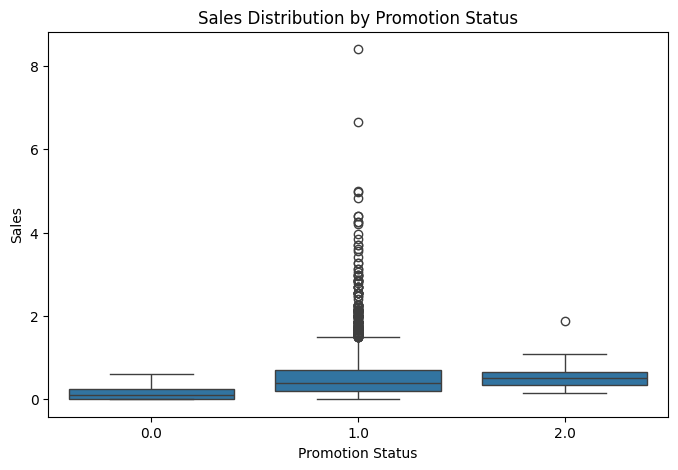

In [506]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='isPromo', y='Sales')
plt.title('Sales Distribution by Promotion Status')
plt.xlabel('Promotion Status')
plt.ylabel('Sales')
plt.show()

- Promotions clearly impact sales, with Promotion 1.0 driving particularly high sales in some instances, as evidenced by the outliers and greater distribution spread.

- The presence of numerous outliers, especially in the Promotion 1.0 group, suggests that sales spikes during promotions can be substantial. It is important to analyze the context of these outliers further to determine if they are meaningful or noise.

- Companies should consider why certain promotions (e.g., Promotion 1.0) yield extreme sales increases and whether these can be repeated or optimized. Conversely, efforts might focus on increasing the effectiveness of Promotion 2.0.

In [507]:
numeric_cols = df.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numeric_cols.corr()

print("Correlation Matrix:")
print(correlation_matrix)

Correlation Matrix:
          isPromo     Sales
isPromo  1.000000  0.474547
Sales    0.474547  1.000000


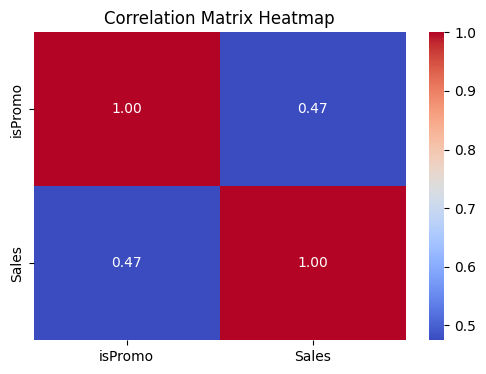

In [508]:
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', cbar=True, fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()

The heatmap shows a moderate positive correlation (0.47) between the isPromo variable and Sales. This indicates that sales tend to increase during promotion periods. While this is not a perfect correlation, it suggests a meaningful relationship where promotions contribute to higher sales, though other factors likely play a role as well.

In [509]:
promo_sales = df[df['isPromo'] > 0]['Sales']
non_promo_sales = df[df['isPromo'] == 0]['Sales']

t_stat, p_value = stats.ttest_ind(promo_sales, non_promo_sales, equal_var=False)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

if p_value < 0.05:
    print("The result is statistically significant: promotions likely have an effect on sales.")
else:
    print("No statistically significant evidence that promotions affect sales.")

T-statistic: 39.4126060816359, P-value: 1.1692683602250165e-279
The result is statistically significant: promotions likely have an effect on sales.


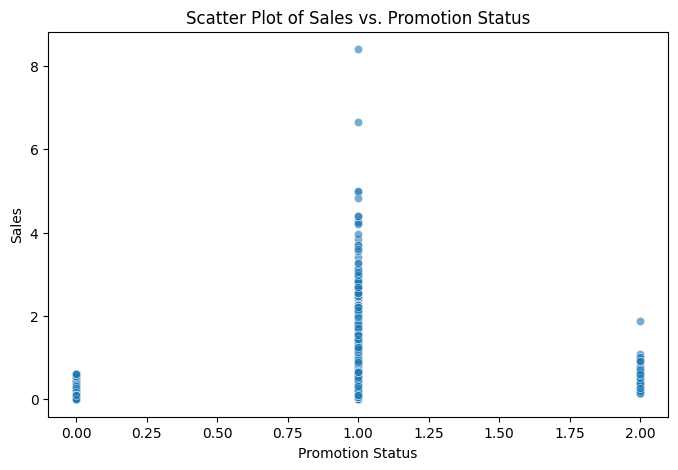

In [510]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='isPromo', y='Sales', alpha=0.6)
plt.title('Scatter Plot of Sales vs. Promotion Status')
plt.xlabel('Promotion Status')
plt.ylabel('Sales')
plt.show()

- There is a dense cluster of data points at isPromo = 0.0, indicating a large number of sales occur without promotions.

- The isPromo = 1.0 category, representing sales during promotion events, shows a broader range of sales values, including some of the highest values observed in the dataset.

- There is a significant contrast between the spread of sales values during promotions (isPromo = 1.0 and isPromo = 2.0) compared to non-promotional periods (isPromo = 0.0), suggesting that promotions can lead to sales spikes.

#### Analysis of Categorical Variables

Check the diversity and distribution of categories for each categorical variable.

Store unique categories: 3


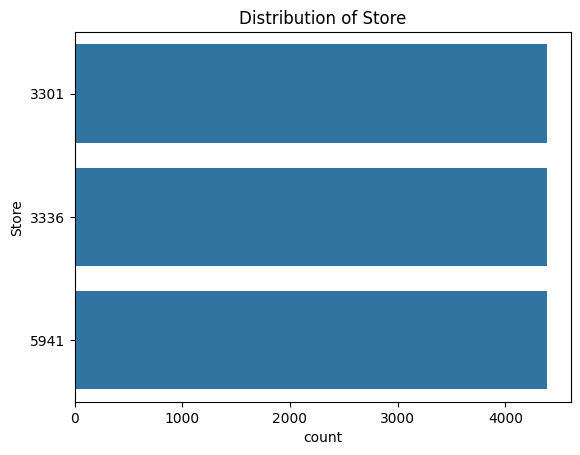

SKU unique categories: 6


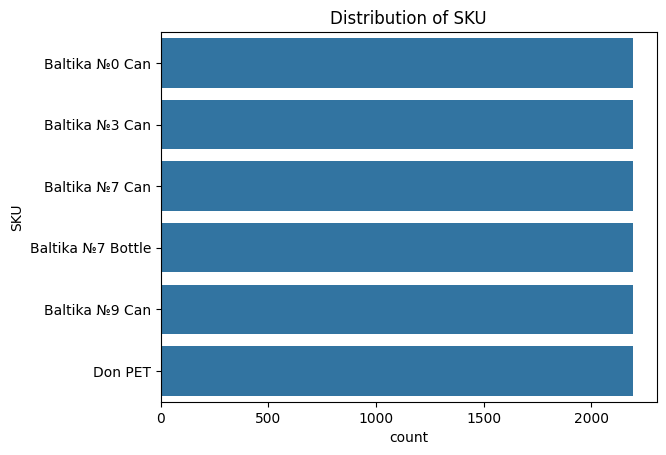

In [511]:
for col in categorical_cols:
    print(f"{col} unique categories: {df[col].nunique()}")
    sns.countplot(y=col, data=df, order=df[col].value_counts().index)
    plt.title(f"Distribution of {col}")
    plt.show()

The data is well distributed across the three stores (3301, 3336, and 5941), with each having a similar number of entries. This indicates a balanced dataset regarding store representation, which is good for analyzing sales trends or promotion impacts across stores.

Similarly, the sales data is evenly distributed across different SKUs, suggesting that each SKU has a comparable amount of sales data. This uniformity is beneficial for comparing sales performance, promotional impacts, and customer preferences across various products.

#### Time Series Aggregation and Exploration

Aggregating data to a weekly scale helps in capturing broader trends relevant to forecasting.

In [512]:
df

,isPromo,Sales,Store,SKU,date
0,0.0,0.100,3301,Baltika №0 Can,2015-06-15
1,0.0,0.350,3301,Baltika №3 Can,2015-06-15
2,1.0,0.600,3301,Baltika №7 Can,2015-06-15
3,1.0,0.350,3301,Baltika №7 Bottle,2015-06-15
4,0.0,0.150,3301,Baltika №9 Can,2015-06-15
...,...,...,...,...,...
13153,0.0,0.000,5941,Baltika №3 Can,2017-06-14
13154,0.0,0.000,5941,Baltika №7 Can,2017-06-14
13155,1.0,0.658,5941,Baltika №7 Bottle,2017-06-14
13156,0.0,0.090,5941,Baltika №9 Can,2017-06-14


In [513]:
def aggregate_to_weekly(df):
    if not pd.api.types.is_datetime64_any_dtype(df.index):
        df['date'] = pd.to_datetime(df['date'])
        df = df.set_index('date')

    weekly = (
        df.groupby(["SKU", "Store"])
        .resample("W")
        .agg({
            "Sales": "sum",
            "isPromo": "max",
        })
        .reset_index()
    )

    return weekly

weekly_df = aggregate_to_weekly(df)
print(weekly_df.head())

              SKU Store       date  Sales  isPromo
0  Baltika №0 Can  3301 2015-06-21   1.00      0.0
1  Baltika №0 Can  3301 2015-06-28   0.70      0.0
2  Baltika №0 Can  3301 2015-07-05   0.40      0.0
3  Baltika №0 Can  3301 2015-07-12   0.75      0.0
4  Baltika №0 Can  3301 2015-07-19   0.40      0.0


**Demand by Day of the Week**

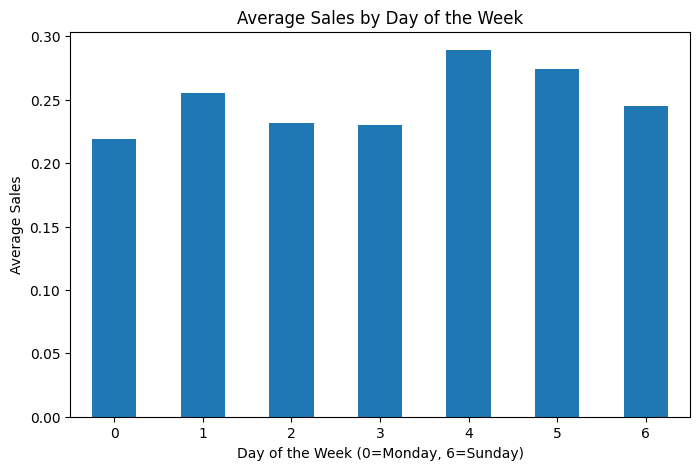

In [514]:
avg_sales_by_day = df.groupby(df['date'].dt.dayofweek)['Sales'].mean()

plt.figure(figsize=(8, 5))
avg_sales_by_day.plot(kind='bar')
plt.title('Average Sales by Day of the Week')
plt.xlabel('Day of the Week (0=Monday, 6=Sunday)')
plt.ylabel('Average Sales')
plt.xticks(rotation=0)
plt.show()

- The data shows a notable peak in average sales on Friday, suggesting that sales tend to increase significantly as the week progresses towards the weekend. This could reflect consumer behavior patterns such as end-of-week shopping or increased purchases in preparation for the weekend.

- Sales appear relatively stable from Monday to Thursday, showing a gradual increase leading to the peak.

- Following the peak on Friday, average sales remain relatively high on Saturday but show a slight drop on Sunday. This pattern may indicate a shift in customer activity, potentially reflecting that consumers buy more before the weekend.

<Figure size 800x400 with 0 Axes>

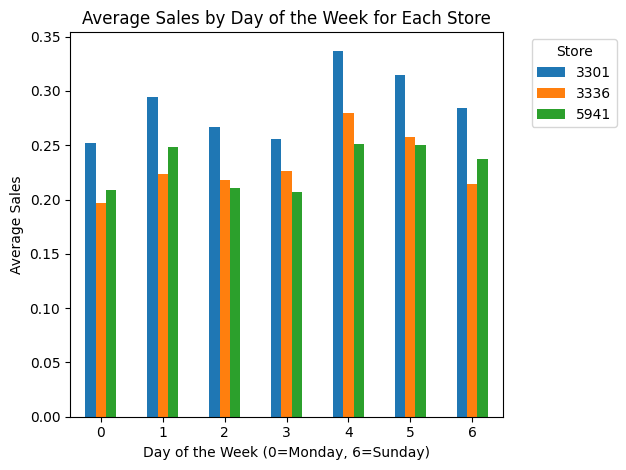

In [515]:
avg_sales_by_day_store = df.groupby([df['date'].dt.dayofweek, 'Store'])['Sales'].mean().unstack()

plt.figure(figsize=(8, 4))
avg_sales_by_day_store.plot(kind='bar')
plt.title('Average Sales by Day of the Week for Each Store')
plt.xlabel('Day of the Week (0=Monday, 6=Sunday)')
plt.ylabel('Average Sales')
plt.xticks(rotation=0)
plt.legend(title='Store', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

 - Store 3301 consistently shows higher average sales across all days of the week compared to the other two stores. This suggests that Store 3301 either has a larger customer base, higher demand, or more effective sales strategies.

- All three stores exhibit a similar trend where sales generally peak on Friday (day 4). This pattern aligns with the broader consumer behavior of increased purchases towards the end of the week.

- Store 3336 shows consistently lower average sales compared to Store 3301 and Store 5941. This suggests potential differences in customer traffic, marketing efforts, or product availability.

- Store 5941 has moderately high sales throughout the week, showing less fluctuation compared to Store 3301 but maintaining a stable performance.

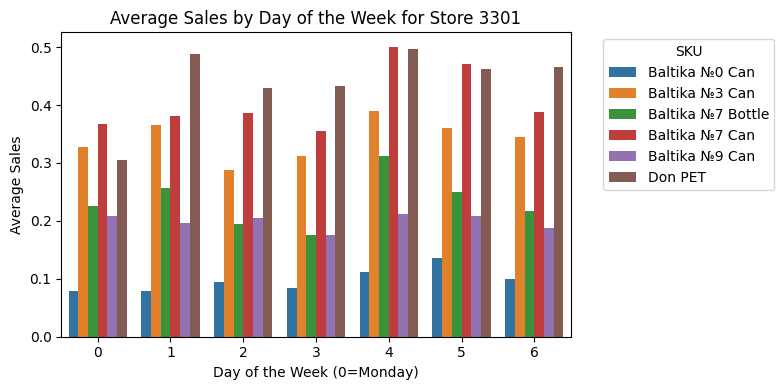

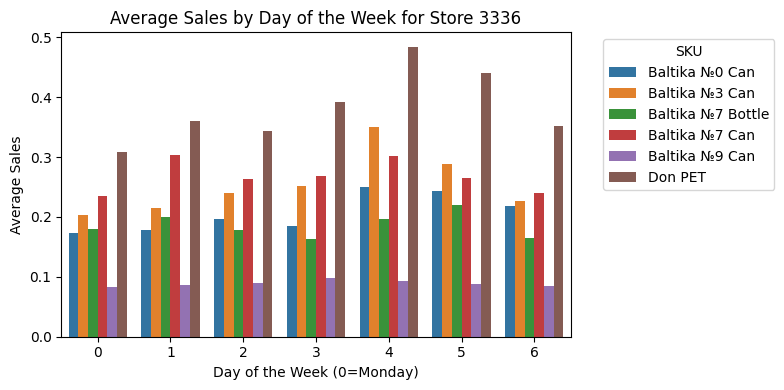

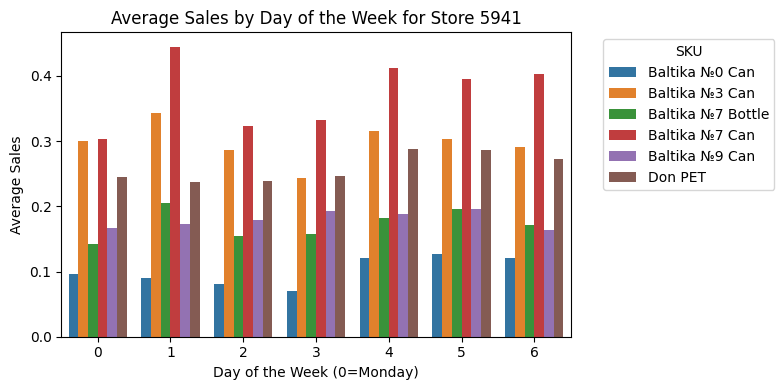

In [516]:
stores = df['Store'].unique()
for store in stores:
    plt.figure(figsize=(8, 4))
    data_subset = df[df['Store'] == store]

    avg_sales_day = data_subset.groupby([data_subset['date'].dt.dayofweek, 'SKU'])['Sales'].mean().reset_index()
    avg_sales_day.columns = ['day_of_week', 'SKU', 'Sales']

    sns.barplot(data=avg_sales_day, x='day_of_week', y='Sales', hue='SKU')
    plt.title(f'Average Sales by Day of the Week for Store {store}')
    plt.xlabel('Day of the Week (0=Monday)')
    plt.ylabel('Average Sales')
    plt.legend(title='SKU', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

**Store 3301:** Don PET generally exhibits the highest average sales across most days, with particularly strong performance on Fridays and weekends. Other products such as Baltika №7 Can and Baltika №3 Can also demonstrate consistent sales.

**Store 3336:** The trend is similar, with Don PET dominating sales, especially towards the weekend. Baltika products show varying levels of demand, with Baltika №3 Can and Baltika №7 Can being consistently present but trailing behind Don PET.

**Store 5941:** This store displays a more evenly distributed average sales pattern for different SKUs compared to the other stores. Baltika №7 Can seems to have slightly higher average sales during weekdays.

Overall, Don PET emerges as a strong performer across all stores, especially towards the weekend, suggesting consistent demand for this product. Variations in demand for Baltika SKUs across different days indicate potential fluctuations based on consumer preferences or store-specific promotions and customer behaviors.

**Demand by Month**

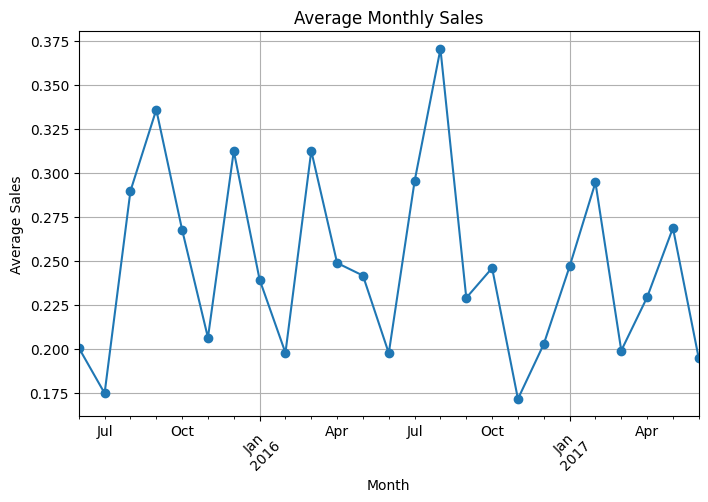

In [517]:
monthly_avg_sales = df.resample('ME', on='date')['Sales'].mean()

plt.figure(figsize=(8, 5))
monthly_avg_sales.plot(kind='line', marker='o')
plt.title('Average Monthly Sales')
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.xticks(rotation=45)
plt.grid(visible=True)
plt.show()

- There is noticeable seasonality and variability in sales across different months, with several pronounced peaks and troughs.

- The peak sales around mid-2016 suggest potential high-demand periods that may correspond to promotions, holidays, or other market factors.

- Sales appear to dip periodically, indicating fluctuations in demand, potentially due to seasonal factors or changes in customer purchasing behavior.

- The clear rise and fall of average sales from month to month could imply the need for better stock and demand planning during peak and low sales periods.

In [518]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date'])

df['Sales'] = pd.to_numeric(df['Sales'], errors='coerce')
df = df.dropna(subset=['Sales'])

monthly_avg_sales = (
    df.groupby(['Store', 'SKU'])
      .resample('ME', on='date')['Sales']
      .mean()
      .reset_index()
)

print(monthly_avg_sales.head())

  Store             SKU       date     Sales
0  3301  Baltika №0 Can 2015-06-30  0.106250
1  3301  Baltika №0 Can 2015-07-31  0.100000
2  3301  Baltika №0 Can 2015-08-31  0.150000
3  3301  Baltika №0 Can 2015-09-30  0.098333
4  3301  Baltika №0 Can 2015-10-31  0.070968


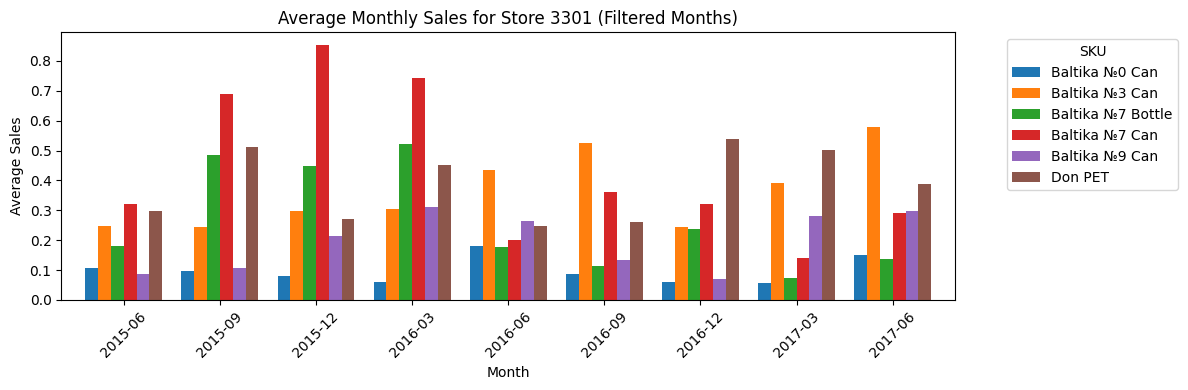

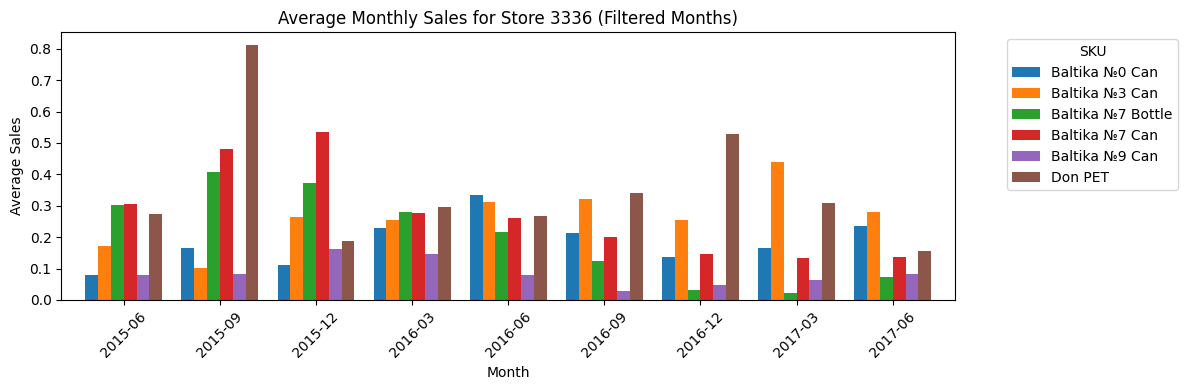

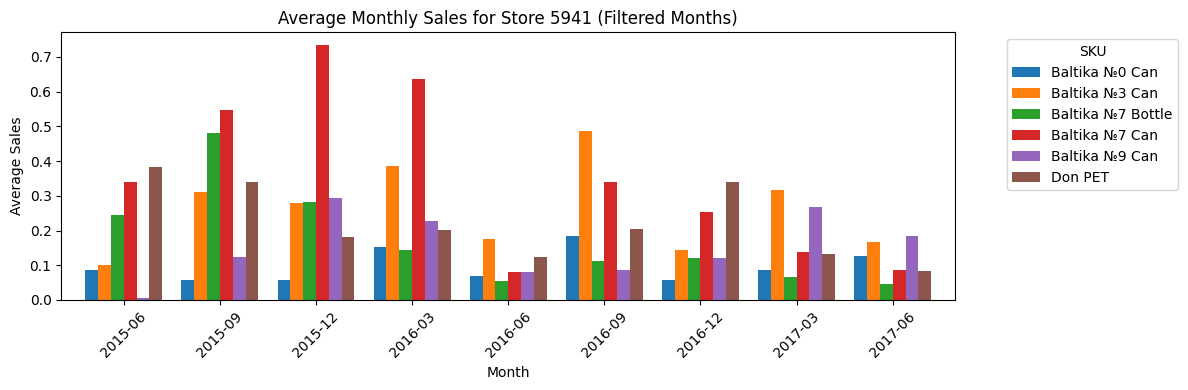

In [519]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date'])

monthly_avg_sales_by_store_sku = df.groupby(['Store', 'SKU']).resample('ME', on='date')['Sales'].mean().reset_index()

stores = monthly_avg_sales_by_store_sku['Store'].unique()
for store in stores:
    plt.figure(figsize=(12, 6))
    store_data = monthly_avg_sales_by_store_sku[monthly_avg_sales_by_store_sku['Store'] == store].copy()  # Use .copy() to avoid potential SettingWithCopyWarning

    store_data.loc[:, 'month_number'] = store_data['date'].dt.month + 12 * store_data['date'].dt.year
    store_data = store_data[store_data['month_number'] % 3 == 0].drop(columns='month_number')

    pivot_data = store_data.pivot(index='date', columns='SKU', values='Sales').fillna(0)
    ax = pivot_data.plot(kind='bar', stacked=False, figsize=(12, 4), width=0.8, ax=plt.gca())

    plt.title(f'Average Monthly Sales for Store {store} (Filtered Months)')
    plt.xlabel('Month')
    plt.ylabel('Average Sales')

    ax.set_xticks(range(len(pivot_data.index)))
    ax.set_xticklabels([date.strftime('%Y-%m') for date in pivot_data.index], rotation=45)

    plt.legend(title='SKU', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

- Sales fluctuate across months, indicating potential seasonality or promotions.

- Certain SKUs, like Don PET, consistently perform better, while others have lower sales.

- Sales patterns differ slightly by store, suggesting local factors at play.

- Monthly spikes likely relate to promotions or demand shifts.

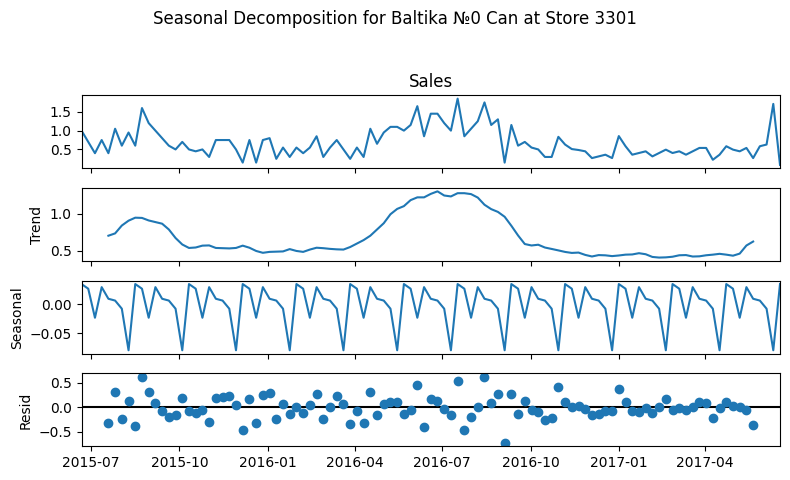

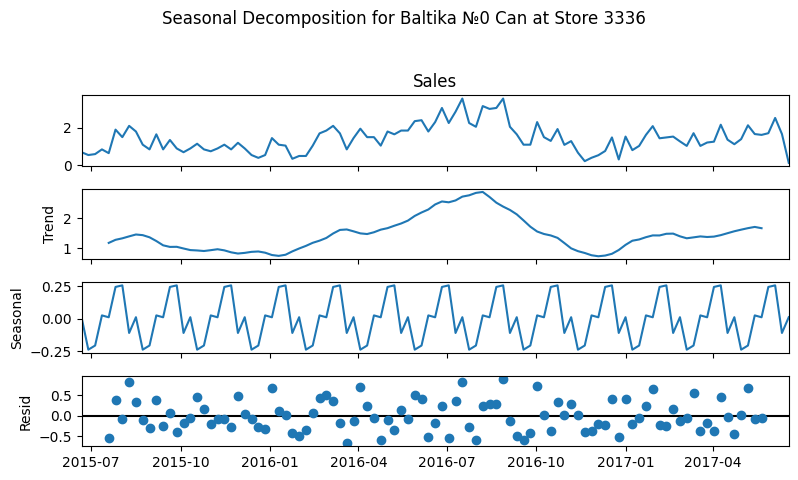

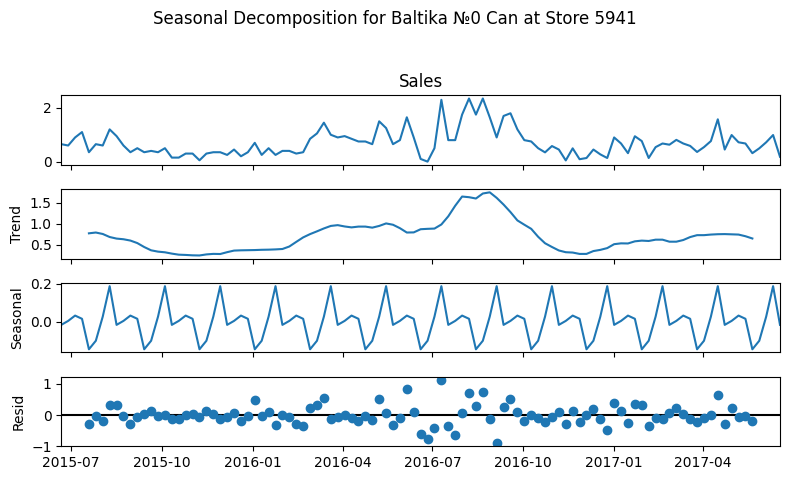

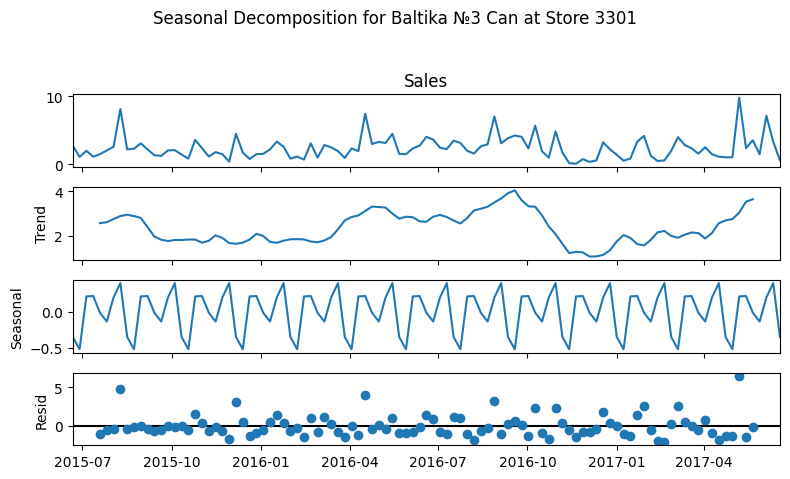

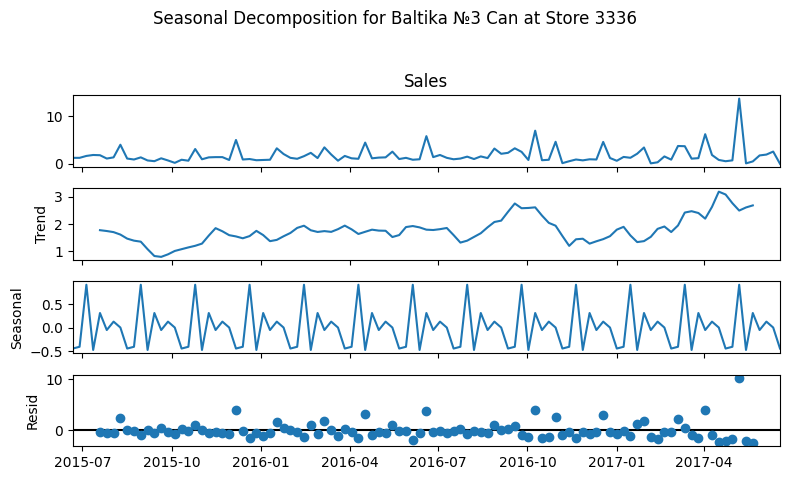

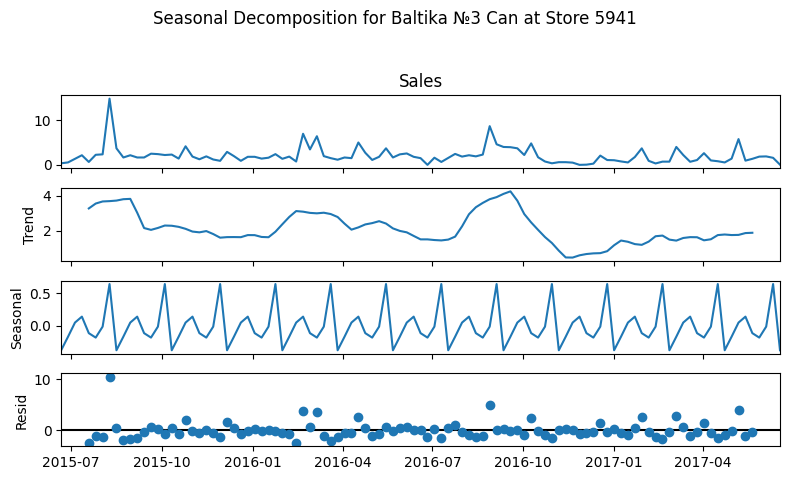

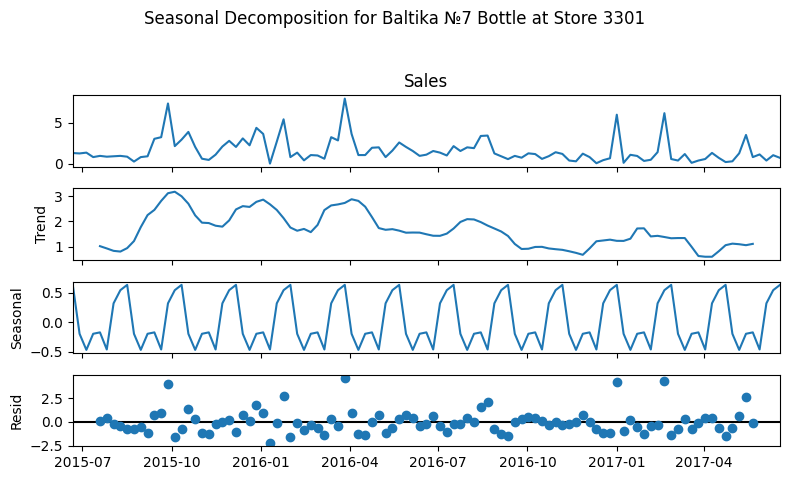

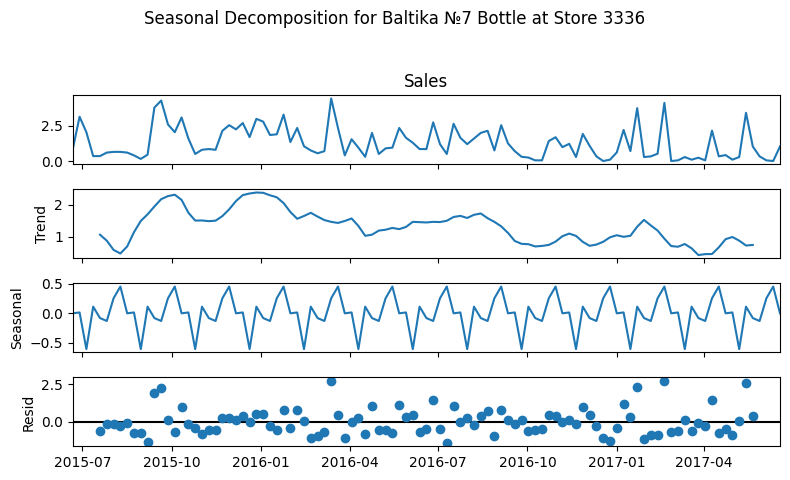

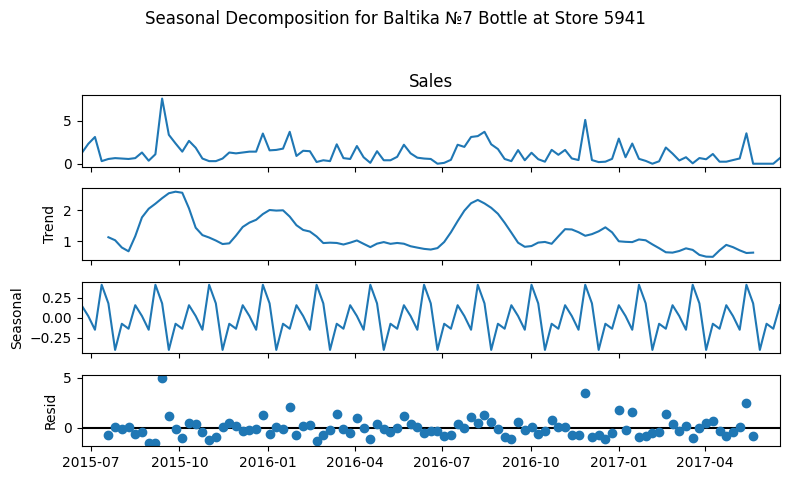

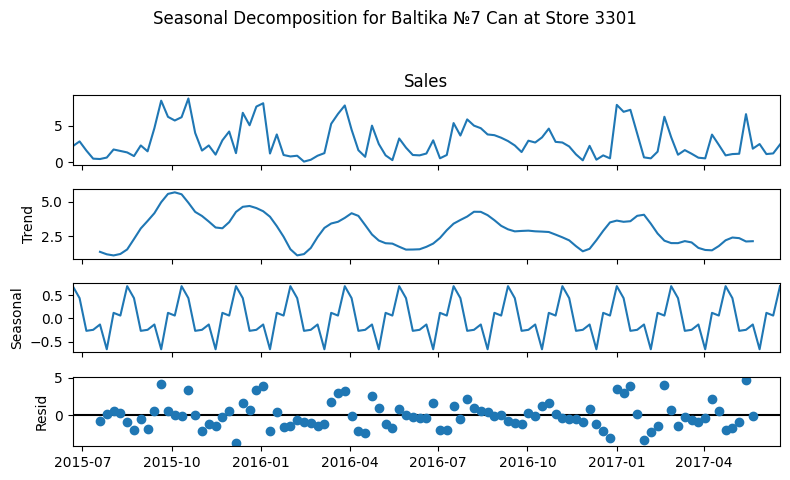

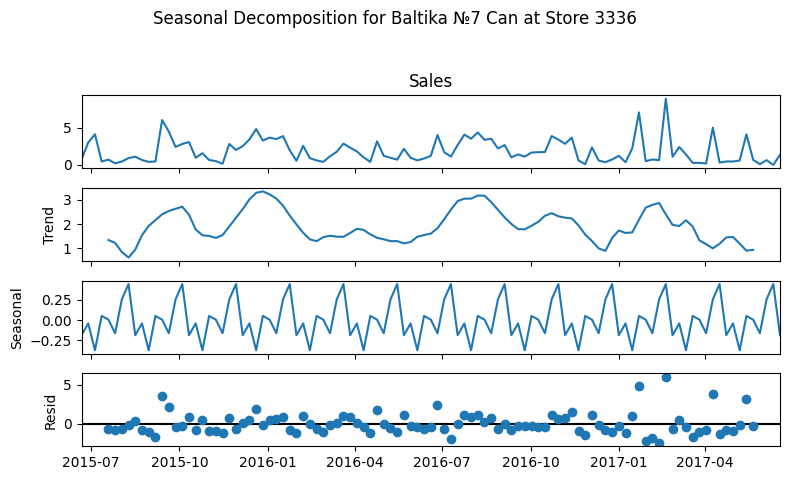

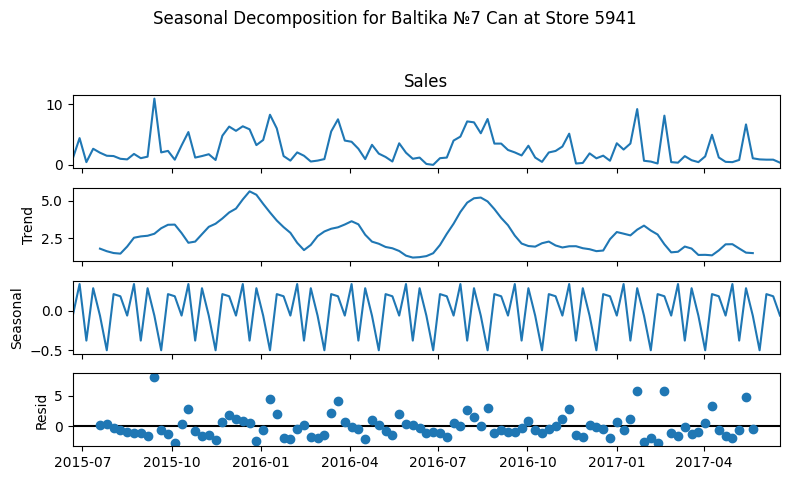

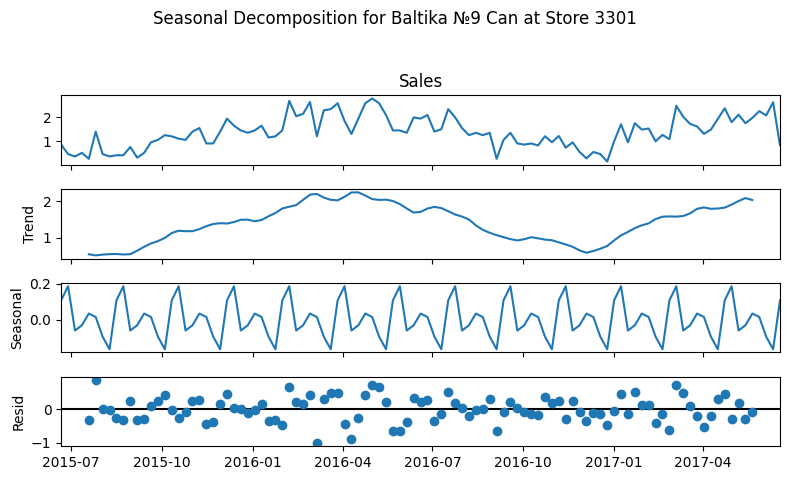

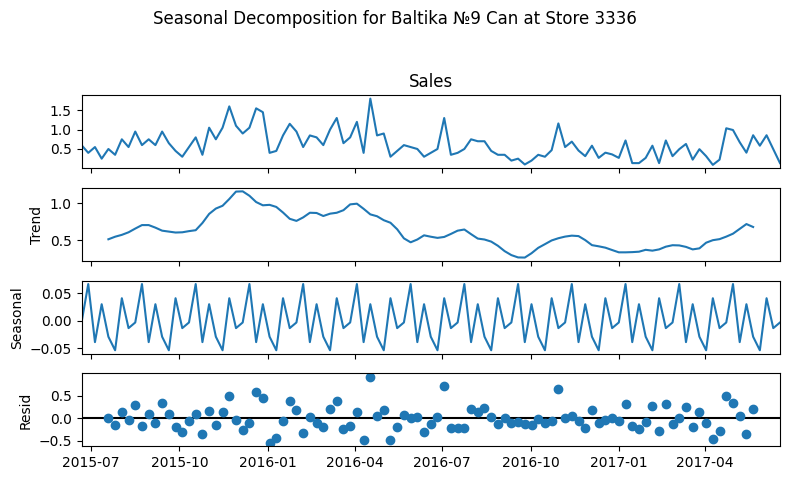

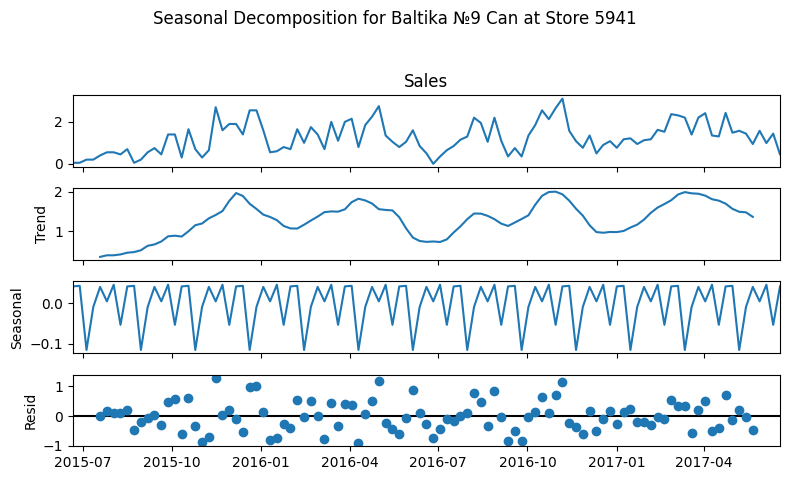

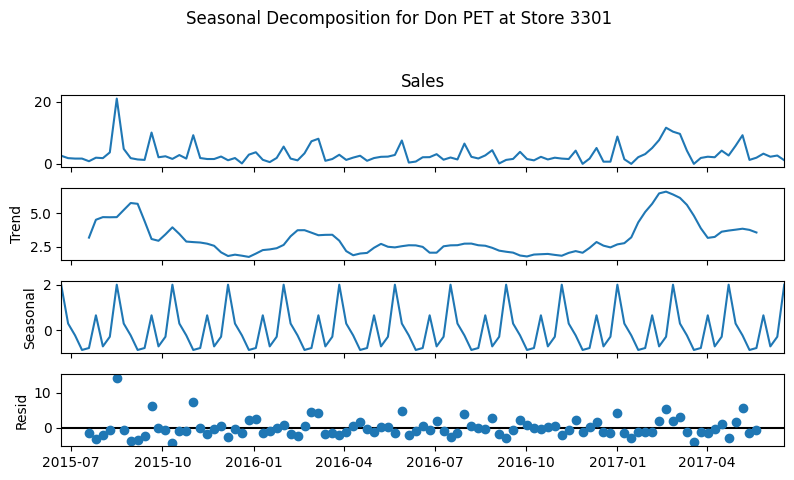

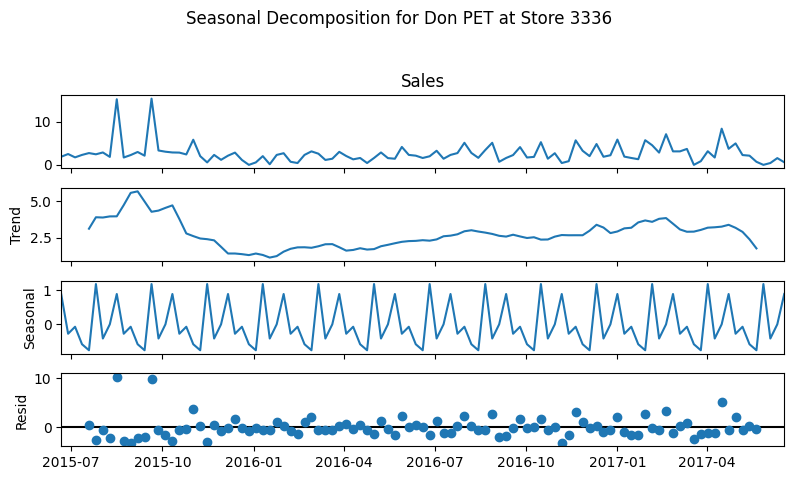

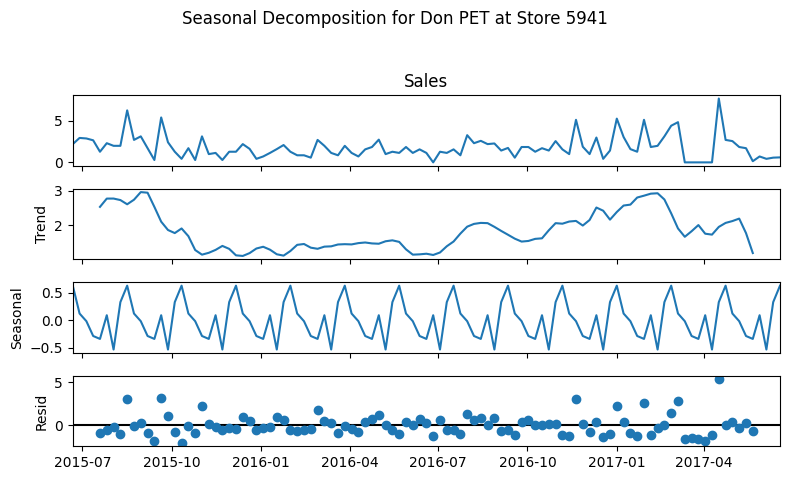

In [520]:
store_sku_combinations = weekly_df[['SKU', 'Store']].drop_duplicates()

for _, row in store_sku_combinations.iterrows():
    sku = row['SKU']
    store = row['Store']
    sample_data = weekly_df[(weekly_df['SKU'] == sku) & (weekly_df['Store'] == store)].sort_values(by='date')

    if len(sample_data) >= 8:
        sample_data = sample_data.set_index('date')
        sample_data = sample_data.asfreq('W')

        decomposition = seasonal_decompose(sample_data['Sales'], model='additive', period=8)

        fig = decomposition.plot()
        fig.set_size_inches(8, 5)
        fig.suptitle(f'Seasonal Decomposition for {sku} at Store {store}', fontsize=12)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

**1) Seasonal Effects:** The clear, periodic peaks and valleys in the seasonal component show that sales are subject to predictable seasonal variations. This might align with consumer behavior patterns, specific seasons, or regular promotional cycles, indicating a strong periodic influence on sales.

**2) Trend Dynamics:** The trend component helps to understand whether a particular product's sales are increasing, decreasing, or remaining stable over time. For instance, some charts indicate a steady growth in demand, while others show a decline or fluctuation, pointing to changes in customer preference, marketing effectiveness, or competition.

**3) Variability Between Stores:** While all stores show seasonality, the extent and pattern of the trends differ across stores for the same product. This suggests that local factors, customer demographics, or store-specific promotions influence the sales behavior differently.

**4) Residual Analysis:** The residuals highlight unexpected changes that are not captured by the seasonality or trend components. Large residual values may represent noise or indicate unanticipated events such as one-off promotions, changes in customer behavior, or external shocks like supply chain disruptions.

**5) Consistency Across Time:** The presence of repeating patterns indicates that historical data can be a reliable predictor for future behavior, provided external disruptions remain limited.


**Sales by Store**

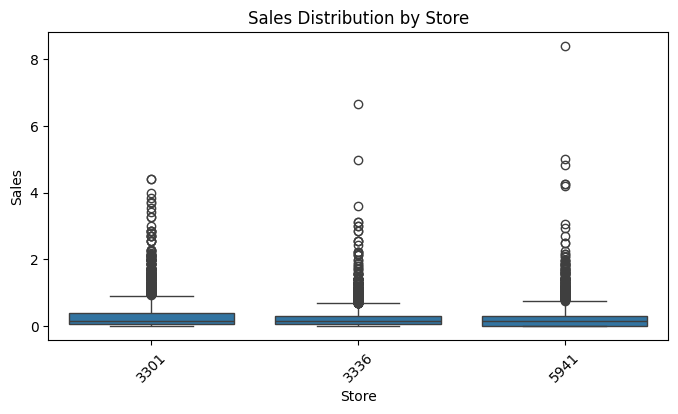

In [521]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=df, x='Store', y='Sales')
plt.title("Sales Distribution by Store")
plt.xlabel("Store")
plt.ylabel("Sales")
plt.xticks(rotation=45)
plt.show()

**1) Similar Distribution Across Stores:** The median sales and the interquartile range (IQR) appear similar across the three stores (3301, 3336, 5941), indicating that, on average, sales performance is relatively consistent across different locations.

**2) Presence of Outliers:** All three stores exhibit a substantial number of high-value outliers, which suggests occasional spikes in sales. These could be due to promotions, seasonal demand, or other store-specific events that drive higher sales volumes during certain periods.

**3) Variation in Maximum Sales:** The maximum sales values (indicated by the highest points) vary across stores, with Store 5941 appearing to have the highest single sales spikes among the three. This may point to a store-specific event or a high-performing product for this particular store.

**4) Sales Concentration:** Most data points are concentrated around lower sales values, with the bulk of sales falling within a narrow range. The consistent clustering across stores implies that the typical day-to-day sales behavior might be similar across these locations.

**Sales by SKU**

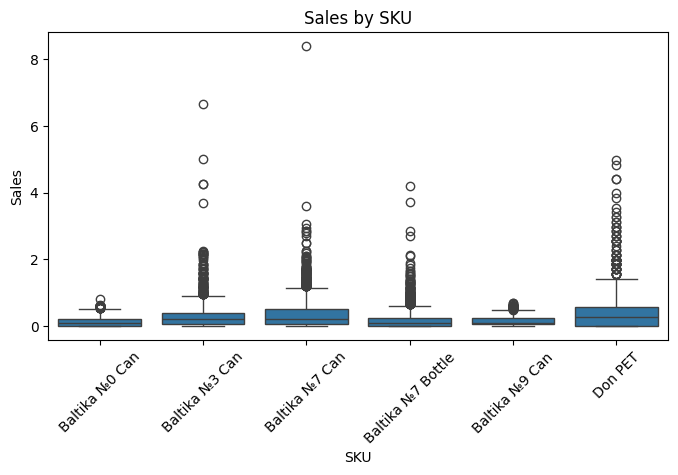

In [522]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=df, x='SKU', y='Sales')
plt.title("Sales by SKU")
plt.xlabel("SKU")
plt.ylabel("Sales")
plt.xticks(rotation=45)
plt.show()

- The SKU "Don PET" exhibits a notably higher range of sales compared to other products, indicating that it could be a top-selling or popular item in the dataset.

- All SKUs display outliers (points beyond the whiskers), suggesting occasional spikes in sales. This may indicate promotional events, seasonal effects, or random high demand instances.

- Some SKUs, like "Baltika №7 Can" and "Baltika №3 Can", have a more spread-out distribution of sales, reflecting a variety of sales levels. In contrast, "Baltika №9 Can" shows a tighter spread around the median, indicating more consistent sales behavior.

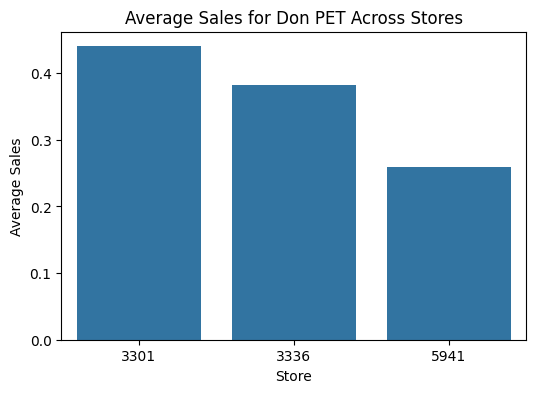

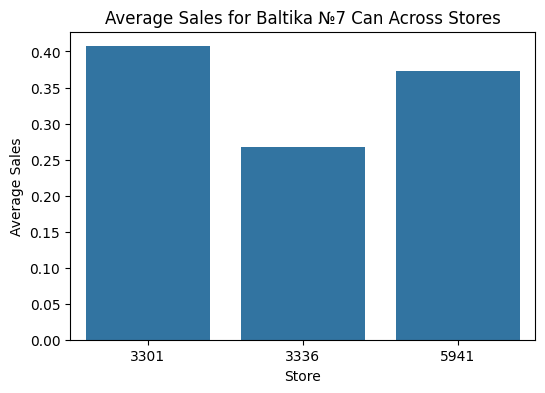

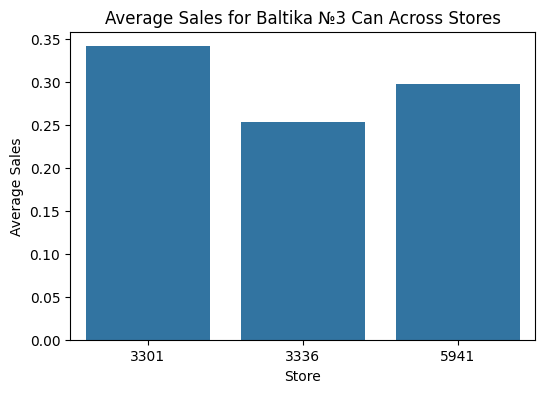

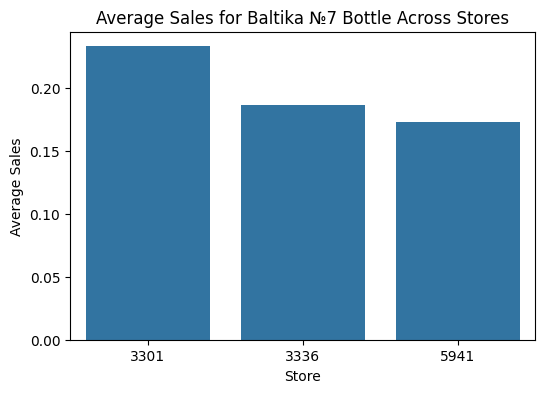

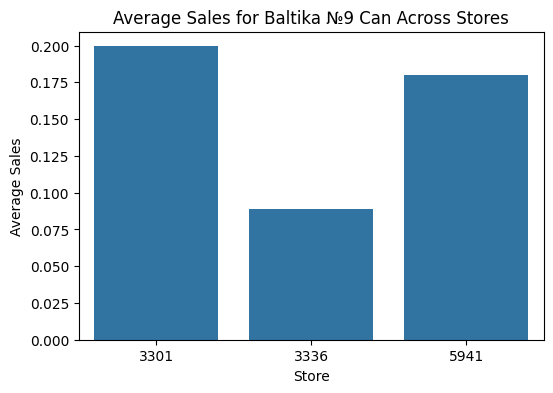

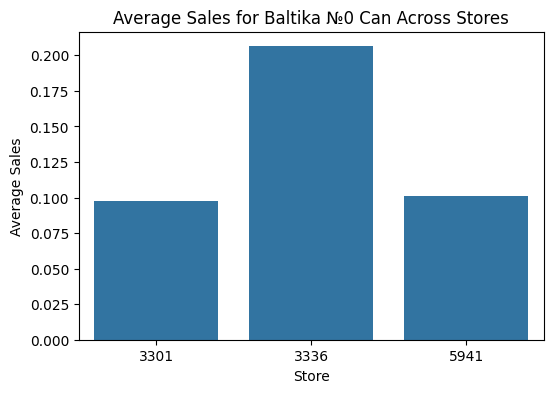

In [523]:
all_skus = df.groupby('SKU')['Sales'].mean().sort_values(ascending=False).head(6).index
all_skus_df = df[df['SKU'].isin(all_skus)]

for sku in all_skus:
    plt.figure(figsize=(6, 4))
    sku_grouped_by_store = all_skus_df[all_skus_df['SKU'] == sku].groupby('Store')['Sales'].mean().reset_index()
    sns.barplot(data=sku_grouped_by_store, x='Store', y='Sales')
    plt.title(f'Average Sales for {sku} Across Stores')
    plt.xlabel('Store')
    plt.ylabel('Average Sales')
    plt.show()

**Sales by SKU and Promotion Status**

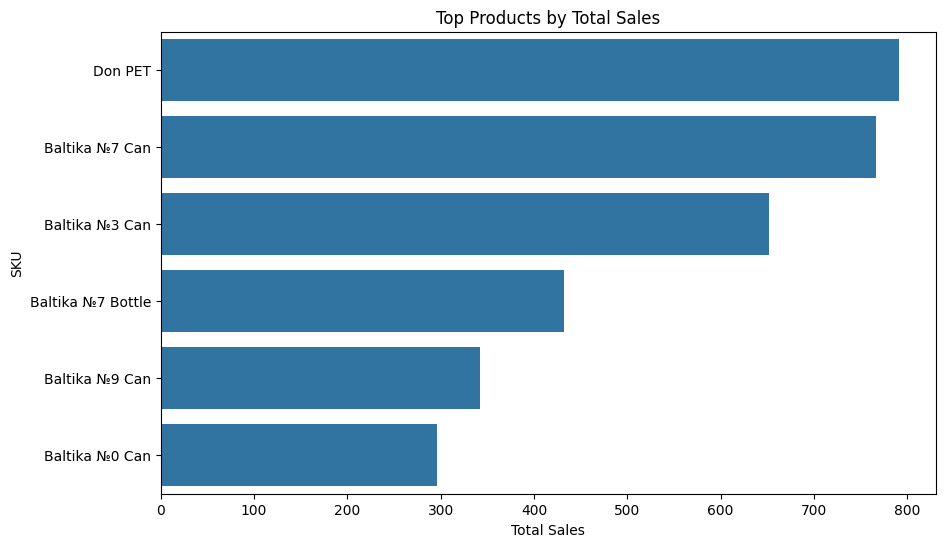

In [524]:
top_products = df.groupby('SKU')['Sales'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_products.values, y=top_products.index)
plt.title('Top Products by Total Sales')
plt.xlabel('Total Sales')
plt.ylabel('SKU')
plt.show()

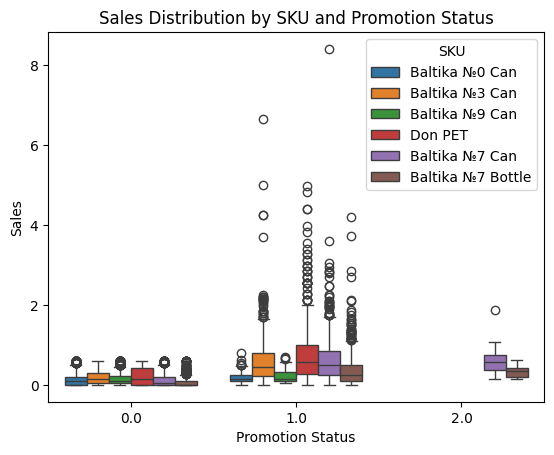

In [525]:
sns.boxplot(data=df, x='isPromo', y='Sales', hue='SKU')
plt.title('Sales Distribution by SKU and Promotion Status')
plt.xlabel('Promotion Status')
plt.ylabel('Sales')
plt.legend(title='SKU')
plt.show()

**1) Promotional Impact:** SKUs under promotion (denoted by isPromo = 1.0 and isPromo = 2.0) generally show a wider spread in sales, often including higher values and more outliers compared to when they are not promoted (isPromo = 0.0). This indicates a positive sales impact due to promotional activities.

**2) SKU-Specific Variance:** Different SKUs respond differently to promotions. For example, Baltika №3 Can and Baltika №7 Can exhibit significantly higher maximum sales during promotions compared to other SKUs. This suggests that certain products may be more sensitive or responsive to promotions than others.

**3) Don PET Performance:** Don PET exhibits a distinct distribution with consistently higher sales values during promotions compared to other SKUs, indicating a strong promotional effect.

**4) Limited Effectiveness for Some SKUs:** Certain SKUs, like Baltika №0 Can and Baltika №9 Can, show relatively less variation in their sales during promotions. This might imply a lower promotional impact for these items or a need for different marketing strategies.

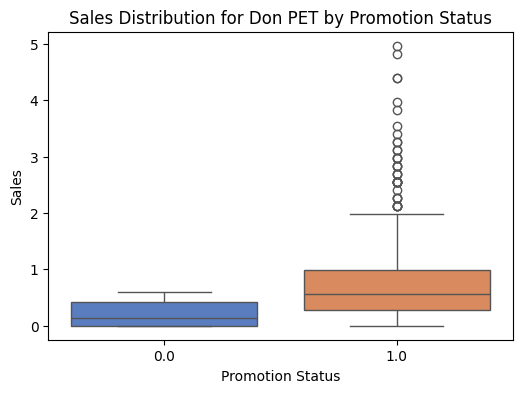

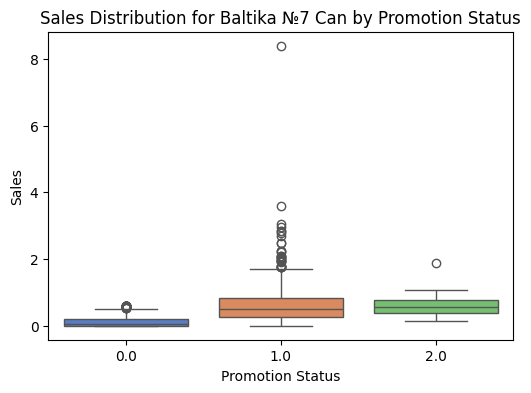

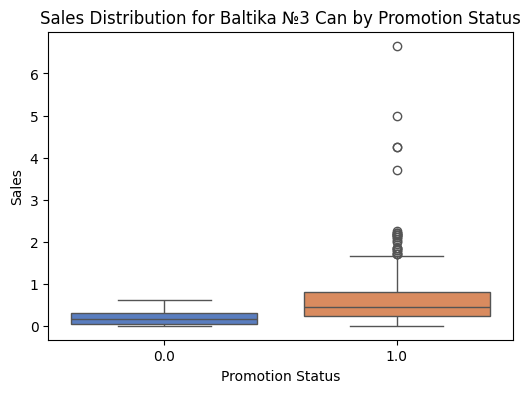

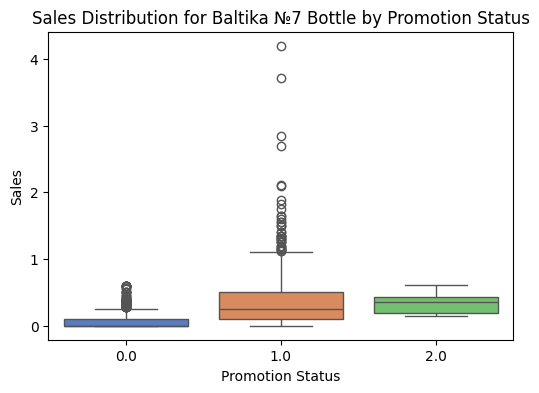

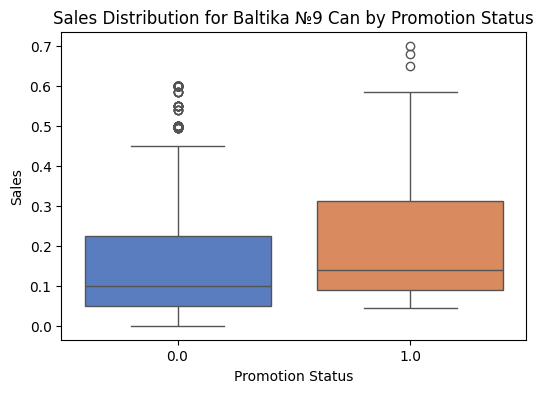

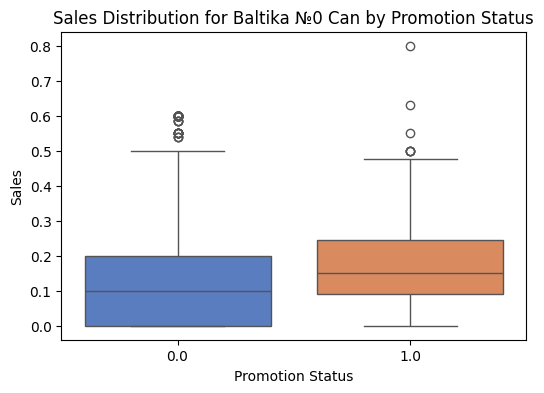

In [526]:
all_skus = df.groupby('SKU')['Sales'].mean().sort_values(ascending=False).head(6).index
all_skus_df = df[df['SKU'].isin(all_skus)]

for sku in all_skus:
    plt.figure(figsize=(6, 4))
    sku_data = all_skus_df[all_skus_df['SKU'] == sku]
    sns.boxplot(data=sku_data, x='isPromo', y='Sales', palette='muted')
    plt.title(f'Sales Distribution for {sku} by Promotion Status')
    plt.xlabel('Promotion Status')
    plt.ylabel('Sales')
    plt.show()

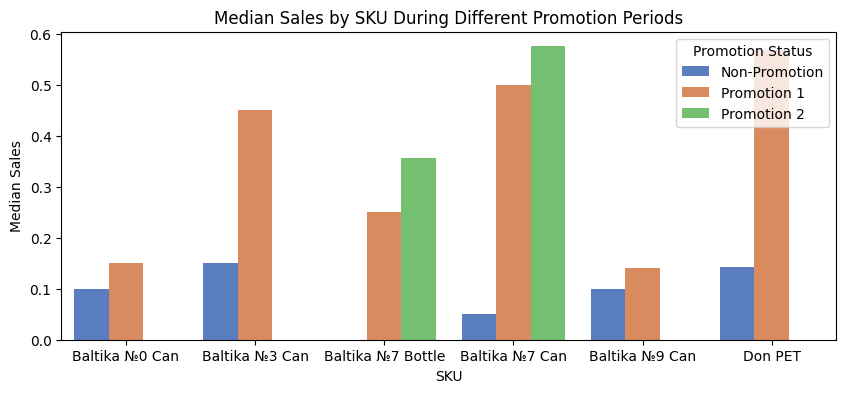

Products with significant sales spikes during promotions (20% increase):
                 SKU  No_Promo_Sales  Promo_1_Sales  Promo_2_Sales  \
0     Baltika №0 Can           0.100          0.150            NaN   
1     Baltika №3 Can           0.150          0.450            NaN   
2  Baltika №7 Bottle           0.000          0.250          0.357   
3     Baltika №7 Can           0.050          0.500          0.575   
4     Baltika №9 Can           0.100          0.140            NaN   
5            Don PET           0.142          0.568            NaN   

   Promo_1_Spike_%  Promo_2_Spike_%  
0             50.0              NaN  
1            200.0              NaN  
2              inf              inf  
3            900.0           1050.0  
4             40.0              NaN  
5            300.0              NaN  


In [527]:
median_sales_by_promo = df.groupby(['SKU', 'isPromo'])['Sales'].median().reset_index()

pivot_df = median_sales_by_promo.pivot(index='SKU', columns='isPromo', values='Sales').reset_index()
pivot_df.columns = ['SKU', 'No_Promo_Sales', 'Promo_1_Sales', 'Promo_2_Sales']

pivot_df['Promo_1_Spike_%'] = ((pivot_df['Promo_1_Sales'] - pivot_df['No_Promo_Sales']) / pivot_df['No_Promo_Sales']) * 100
pivot_df['Promo_2_Spike_%'] = ((pivot_df['Promo_2_Sales'] - pivot_df['No_Promo_Sales']) / pivot_df['No_Promo_Sales']) * 100

plt.figure(figsize=(10, 4))
sns.barplot(data=pivot_df.melt(id_vars=['SKU'], value_vars=['No_Promo_Sales', 'Promo_1_Sales', 'Promo_2_Sales']),
            x='SKU', y='value', hue='variable', errorbar=None, palette='muted')
plt.xlabel('SKU')
plt.ylabel('Median Sales')
plt.title('Median Sales by SKU During Different Promotion Periods')
plt.legend(title='Promotion Status', labels=['Non-Promotion', 'Promotion 1', 'Promotion 2'], loc='upper right')
plt.show()

significant_spikes = pivot_df[(pivot_df['Promo_1_Spike_%'] > 20) | (pivot_df['Promo_2_Spike_%'] > 20)]
print("Products with significant sales spikes during promotions (20% increase):")
print(significant_spikes)

- Across most SKUs, sales median values increase during promotions (Promotion 1 and Promotion 2) compared to non-promotional periods. This confirms that promotional activities have a significant positive impact on boosting sales for these products.

- Baltika №3 Can and Baltika №7 Can show the most pronounced increase in median sales during promotions. This suggests that these items are particularly responsive to promotional efforts, making them strong candidates for future promotional campaigns.

- The degree of improvement varies by SKU, with some SKUs like Baltika №0 Can and Baltika №9 Can showing less dramatic changes. This indicates that promotional effectiveness is SKU-dependent, possibly influenced by factors such as customer preference, competition, or marketing approach.

- For some SKUs (e.g., Baltika №7 Can), Promotion 2 has an even greater impact than Promotion 1, suggesting that different promotion types or intensities may yield varying levels of effectiveness.

                  SKU Store  promotion_count
0      Baltika №0 Can  3301               30
1      Baltika №0 Can  3336               34
2      Baltika №0 Can  5941               21
3      Baltika №3 Can  3301              180
4      Baltika №3 Can  3336              174
5      Baltika №3 Can  5941              171
6   Baltika №7 Bottle  3301              329
7   Baltika №7 Bottle  3336              320
8   Baltika №7 Bottle  5941              300
9      Baltika №7 Can  3301              337
10     Baltika №7 Can  3336              332
11     Baltika №7 Can  5941              320
12     Baltika №9 Can  3301                6
13     Baltika №9 Can  3336               21
14     Baltika №9 Can  5941               21
15            Don PET  3301              202
16            Don PET  3336              211
17            Don PET  5941              177


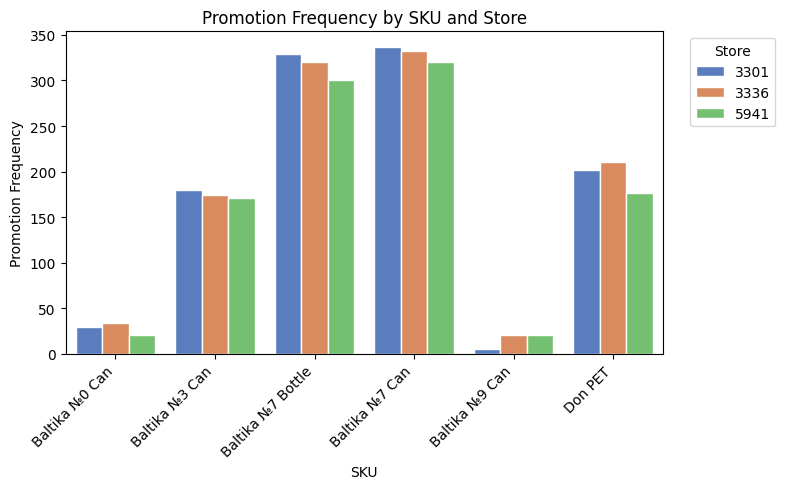

In [528]:
promotions = df[df['isPromo'] > 0]
promotion_counts = promotions.groupby(['SKU', 'Store']).size().reset_index(name='promotion_count')

print(promotion_counts)

plt.figure(figsize=(8, 5))
sns.barplot(
    data=promotion_counts,
    x='SKU',
    y='promotion_count',
    hue='Store',
    palette='muted',
    edgecolor='w'
)

plt.xlabel('SKU')
plt.ylabel('Promotion Frequency')
plt.title('Promotion Frequency by SKU and Store')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Store', loc='upper right', bbox_to_anchor=(1.2, 1))
plt.tight_layout()
plt.show()


The chart shows that Baltika №7 products (Can and Bottle) have the highest promotion frequency across all stores, indicating their strategic importance. Promotions are generally consistent across stores, with slight variations reflecting store-specific strategies. Lower promotion frequencies for Baltika №0 and Baltika №9 suggest they are less reliant on promotions. Overall, the emphasis is on high-impact SKUs to drive sales.

#### Identify Most Popular SKU-Supermarket Combination

In [529]:
grouped_sales = df.groupby(['Store', 'SKU'])['Sales'].mean().reset_index()
most_popular_combination = grouped_sales.sort_values(by='Sales', ascending=False).head(1)

print("Most Popular Store-SKU Combination:")
print(most_popular_combination)

Most Popular Store-SKU Combination:
  Store      SKU     Sales
5  3301  Don PET  0.440005


In [530]:
total_sales_all = df['Sales'].sum()
most_popular_store = most_popular_combination['Store'].iloc[0]
most_popular_sku = most_popular_combination['SKU'].iloc[0]

total_sales_most_popular = df[(df['Store'] == most_popular_store) & (df['SKU'] == most_popular_sku)]['Sales'].sum()
percentage_demand = (total_sales_most_popular / total_sales_all) * 100

print("Total Sales for Most Popular Combination:", round(total_sales_most_popular))
print("Percentage of Total Sales:", round(percentage_demand, 2), "%")

Total Sales for Most Popular Combination: 322
Percentage of Total Sales: 9.81 %


Finding all combinations with their total demand and percentage

In [531]:
total_sales_all = df['Sales'].sum()
grouped_sales = df.groupby(['Store', 'SKU'])['Sales'].sum().reset_index()
grouped_sales.columns = ['Store', 'SKU', 'Total Sales']
grouped_sales['Percentage of Total Sales'] = (grouped_sales['Total Sales'] / total_sales_all) * 100

for _, row in grouped_sales.iterrows():
    print(f"Store: {row['Store']}, SKU: {row['SKU']}")
    print(f"Total Sales: {round(row['Total Sales'])}")
    print(f"Percentage of Total Sales: {round(row['Percentage of Total Sales'], 2)} %\n")

Store: 3301, SKU: Baltika №0 Can
Total Sales: 71
Percentage of Total Sales: 2.17 %

Store: 3301, SKU: Baltika №3 Can
Total Sales: 250
Percentage of Total Sales: 7.61 %

Store: 3301, SKU: Baltika №7 Bottle
Total Sales: 170
Percentage of Total Sales: 5.19 %

Store: 3301, SKU: Baltika №7 Can
Total Sales: 298
Percentage of Total Sales: 9.07 %

Store: 3301, SKU: Baltika №9 Can
Total Sales: 146
Percentage of Total Sales: 4.44 %

Store: 3301, SKU: Don PET
Total Sales: 322
Percentage of Total Sales: 9.81 %

Store: 3336, SKU: Baltika №0 Can
Total Sales: 151
Percentage of Total Sales: 4.6 %

Store: 3336, SKU: Baltika №3 Can
Total Sales: 185
Percentage of Total Sales: 5.64 %

Store: 3336, SKU: Baltika №7 Bottle
Total Sales: 136
Percentage of Total Sales: 4.15 %

Store: 3336, SKU: Baltika №7 Can
Total Sales: 196
Percentage of Total Sales: 5.98 %

Store: 3336, SKU: Baltika №9 Can
Total Sales: 65
Percentage of Total Sales: 1.98 %

Store: 3336, SKU: Don PET
Total Sales: 280
Percentage of Total Sales:

### Conclusions

**1. Data Overview & Cleaning**
- The dataset consists of sales data across multiple stores for different SKUs, with promotion status indicated.

- Data was cleaned by converting dates, handling missing values, and treating outliers using capping and noise detection approaches.

**2. Missing Data Analysis**
- There were no missing values in critical columns after processing.

- Data completeness facilitated accurate analyses of sales trends, promotions, and store-specific behaviors.

**3. Outlier Treatment**
- Identified potential noise in sales data that did not align with holidays or promotions.

- Outliers were addressed using methods like capping and classification as noise to ensure data quality without distortions.

**4. Sales Patterns by SKU, Store, and Promotion Status**

- **General Sales Trends:** Sales varied across SKUs, with some (e.g., Baltika №7 products) showing higher average sales.

- **Store Comparison:** Store-specific patterns were evident, with different levels of sales and promotional effectiveness. Stores exhibited unique weekly and seasonal sales behaviors.

- **Promotion Impact:** Promotions significantly increased sales across SKUs, particularly Baltika №7 Can and Don PET. However, not all SKUs responded equally to promotions.

**5. Seasonal and Trend Analysis**
- Seasonal decomposition highlighted consistent seasonality across SKUs, with peaks during specific months.

- Trend components indicated increasing or stabilizing sales trends for key products over time.

**6. Sales Distribution Analysis**

- Sales distributions were skewed, with promotions shifting median and mean values significantly higher for many SKUs.

- Outliers were more prevalent during promotional periods, suggesting occasional highly successful promotions.

**7. Promotion Strategy Insights**
- Promotions are heavily focused on a few key SKUs.

- High promotional frequency for Baltika №7 products suggests their centrality to sales strategy.

- Stores tend to follow similar promotion patterns, but some variation exists, offering room for store-specific promotion optimization.

**8. Recommendations**
- **Promotion Optimization:** Target promotions for high-impact SKUs like Baltika №7 and Don PET more strategically to maximize sales without oversaturation.

- **SKU Diversification:** Consider extending promotions to underutilized SKUs to increase their market share and broaden product reach.

- **Seasonal Strategies:** Leverage identified seasonal peaks by aligning promotions and stock replenishments.

- **Store-Specific Strategies:** Tailor promotions based on store-specific sales patterns and performance to maximize efficiency.

- **Continuous Monitoring:** Implement continuous monitoring and re-evaluation of sales and promotion impact for timely adjustments to strategy.

# Feature engineering and data preparation

In [532]:
df

,isPromo,Sales,Store,SKU,date
0,0.0,0.100,3301,Baltika №0 Can,2015-06-15
1,0.0,0.350,3301,Baltika №3 Can,2015-06-15
2,1.0,0.600,3301,Baltika №7 Can,2015-06-15
3,1.0,0.350,3301,Baltika №7 Bottle,2015-06-15
4,0.0,0.150,3301,Baltika №9 Can,2015-06-15
...,...,...,...,...,...
13153,0.0,0.000,5941,Baltika №3 Can,2017-06-14
13154,0.0,0.000,5941,Baltika №7 Can,2017-06-14
13155,1.0,0.658,5941,Baltika №7 Bottle,2017-06-14
13156,0.0,0.090,5941,Baltika №9 Can,2017-06-14


In [534]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['day_of_week'] = df['date'].dt.dayofweek
df['is_fri_sat'] = df['day_of_week'].isin([4, 5]).astype(int)
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

df = df.sort_values(by='date')
df['rolling_avg_7d'] = df.groupby(['SKU', 'Store'])['Sales'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())
df['rolling_std_7d'] = df.groupby(['SKU', 'Store'])['Sales'].transform(lambda x: x.rolling(window=7, min_periods=1).std())

promo_threshold = df[df['isPromo'] > 0]['Sales'].quantile(0.9)
df['is_promo_high'] = ((df['isPromo'] > 0) & (df['Sales'] > promo_threshold)).astype(int)

df['store_sku_cum_mean'] = df.groupby(['SKU', 'Store'])['Sales'].expanding().mean().reset_index(level=[0, 1], drop=True)
df['sku_popularity'] = df.groupby(['SKU', 'Store'])['Sales'].transform('mean')

df = df.sort_values(by=['SKU', 'Store', 'date'])
df['lag_1w'] = df.groupby(['SKU', 'Store'])['Sales'].shift(7)
df['lag_2w'] = df.groupby(['SKU', 'Store'])['Sales'].shift(14)

df['lag_1w'].fillna(0, inplace=True)
df['lag_2w'].fillna(0, inplace=True)
df['rolling_std_7d'].fillna(df['rolling_std_7d'].mean(), inplace=True)

df['cumulative_sales'] = df.groupby(['SKU', 'Store'])['Sales'].cumsum()
df['store_encoded'] = df['Store'].astype('category').cat.codes
df['sku_encoded'] = df['SKU'].astype('category').cat.codes

print(df.head())

    isPromo  Sales Store             SKU       date  day_of_week  is_fri_sat  \
0       0.0   0.10  3301  Baltika №0 Can 2015-06-15            0           0   
18      0.0   0.05  3301  Baltika №0 Can 2015-06-16            1           0   
36      0.0   0.20  3301  Baltika №0 Can 2015-06-17            2           0   
54      0.0   0.20  3301  Baltika №0 Can 2015-06-18            3           0   
72      0.0   0.10  3301  Baltika №0 Can 2015-06-19            4           1   

    month  year  rolling_avg_7d  rolling_std_7d  is_promo_high  \
0       6  2015        0.100000        0.201440              0   
18      6  2015        0.075000        0.035355              0   
36      6  2015        0.116667        0.076376              0   
54      6  2015        0.137500        0.075000              0   
72      6  2015        0.130000        0.067082              0   

    store_sku_cum_mean  sku_popularity  lag_1w  lag_2w  cumulative_sales  \
0             0.100000        0.097579     0.0

In [535]:
df

,isPromo,Sales,Store,SKU,date,day_of_week,is_fri_sat,month,year,rolling_avg_7d,rolling_std_7d,is_promo_high,store_sku_cum_mean,sku_popularity,lag_1w,lag_2w,cumulative_sales,store_encoded,sku_encoded
0,0.0,0.10,3301,Baltika №0 Can,2015-06-15,0,0,6,2015,0.100000,0.201440,0,0.100000,0.097579,0.0,0.000,0.100,0,0
18,0.0,0.05,3301,Baltika №0 Can,2015-06-16,1,0,6,2015,0.075000,0.035355,0,0.075000,0.097579,0.0,0.000,0.150,0,0
36,0.0,0.20,3301,Baltika №0 Can,2015-06-17,2,0,6,2015,0.116667,0.076376,0,0.116667,0.097579,0.0,0.000,0.350,0,0
54,0.0,0.20,3301,Baltika №0 Can,2015-06-18,3,0,6,2015,0.137500,0.075000,0,0.137500,0.097579,0.0,0.000,0.550,0,0
72,0.0,0.10,3301,Baltika №0 Can,2015-06-19,4,1,6,2015,0.130000,0.067082,0,0.130000,0.097579,0.0,0.000,0.650,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13085,0.0,0.00,5941,Don PET,2017-06-10,5,1,6,2017,0.081143,0.161013,0,0.259840,0.259239,0.0,0.142,188.904,2,5
13103,0.0,0.00,5941,Don PET,2017-06-11,6,0,6,2017,0.081143,0.161013,0,0.259484,0.259239,0.0,0.142,188.904,2,5
13121,0.0,0.00,5941,Don PET,2017-06-12,0,0,6,2017,0.081143,0.161013,0,0.259128,0.259239,0.0,0.142,188.904,2,5
13139,0.0,0.00,5941,Don PET,2017-06-13,1,0,6,2017,0.081143,0.161013,0,0.258773,0.259239,0.0,0.284,188.904,2,5


In [ ]:
import tensorflow as tf
import warnings

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from datetime import timedelta

In [536]:
warnings.filterwarnings("ignore")

df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.sort_values(by='date')

X = df.drop(columns=['Sales', 'date', 'Store', 'SKU'])
y = df['Sales']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_lstm = np.array(X_scaled).reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
y_lstm = np.array(y)

models = {
    'Ridge': (Ridge(), {'alpha': [0.01, 0.1, 1]}),
    'RandomForest': (RandomForestRegressor(), {'n_estimators': [100], 'max_depth': [5]}),
    'XGBoost': (XGBRegressor(objective='reg:squarederror'), {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5],
        'subsample': [0.8],
        'colsample_bytree': [0.8]
    })
}

def build_lstm_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(50, activation='relu', input_shape=input_shape),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

tscv = TimeSeriesSplit(n_splits=3)
results = {}

for model_name, (model, param_grid) in models.items():
    mae_scores = []
    rmse_scores = []
    feature_importances = None

    for train_index, test_index in tscv.split(X_scaled):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_absolute_error', cv=3, n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))

        mae_scores.append(mae)
        rmse_scores.append(rmse)

        if model_name in ['RandomForest', 'XGBoost']:
            feature_importances = best_model.feature_importances_

    results[model_name] = {
        'Best Params': grid_search.best_params_,
        'MAE': np.mean(mae_scores),
        'RMSE': np.mean(rmse_scores),
        'Feature Importances': feature_importances
    }

mae_scores_lstm = []
rmse_scores_lstm = []

for train_index, test_index in tscv.split(X_lstm):
    X_train, X_test = X_lstm[train_index], X_lstm[test_index]
    y_train, y_test = y_lstm[train_index], y_lstm[test_index]

    lstm_model = build_lstm_model((X_train.shape[1], X_train.shape[2]))
    lstm_model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)  # Reduced epochs for faster training

    y_pred = lstm_model.predict(X_test).flatten()
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    mae_scores_lstm.append(mae)
    rmse_scores_lstm.append(rmse)

results['LSTM'] = {
    'Best Params': 'N/A (Deep Learning Model)',
    'MAE': np.mean(mae_scores_lstm),
    'RMSE': np.mean(rmse_scores_lstm)
}

for model_name, metrics in results.items():
    print(f"Model: {model_name}")
    print(f"  Best Parameters: {metrics['Best Params']}")
    print(f"  Mean MAE: {metrics['MAE']:.4f}")
    print(f"  Mean RMSE: {metrics['RMSE']:.4f}\n")

    if 'Feature Importances' in metrics and metrics['Feature Importances'] is not None:
        print(f"Feature Importances for {model_name}:")
        feature_importance_list = zip(X.columns, metrics['Feature Importances'])
        sorted_importance = sorted(feature_importance_list, key=lambda x: x[1], reverse=True)
        for feature, importance in sorted_importance:
            print(f"  {feature}: {importance:.4f}")
        print("\n")

103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Model: Ridge
  Best Parameters: {'alpha': 1}
  Mean MAE: 0.1698
  Mean RMSE: 0.2338

Model: RandomForest
  Best Parameters: {'max_depth': 5, 'n_estimators': 100}
  Mean MAE: 0.1317
  Mean RMSE: 0.1841

Feature Importances for RandomForest:
  is_promo_high: 0.5616
  rolling_avg_7d: 0.2151
  rolling_std_7d: 0.1399
  isPromo: 0.0619
  cumulative_sales: 0.0057
  lag_2w: 0.0050
  store_sku_cum_mean: 0.0032
  day_of_week: 0.0025
  lag_1w: 0.0024
  sku_popularity: 0.0013
  month: 0.0005
  is_fri_sat: 0.0004
  sku_encoded: 0.0002
  store_encoded: 0.0002
  year: 0.0000


Model: XGBoost
  Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
  Mean MAE: 0.1300
  Mean RMSE: 0.1837

Feature Importances for XGBoost:
  is_promo_high: 0.7588
  rolling_avg_7d: 0.0648
  isPromo: 0.0640
  rolling_std_7d: 0.0314
  sku

Model Selection: Based on the lower MAE and RMSE, I proceed with using XGBoost for making future predictions.

In [299]:
if len(X_train.shape) > 2:
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[2])
if len(X_test.shape) > 2:
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[2])

xgb_final_model = XGBRegressor(objective='reg:squarederror',
                               n_estimators=50,
                               learning_rate=0.1)

xgb_final_model.fit(X_train, y_train)

y_train_pred = xgb_final_model.predict(X_train)
mae_train = mean_absolute_error(y_train, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))

print("Final XGBoost Model Training Performance:")
print(f"  MAE (Training): {mae_train:.4f}")
print(f"  RMSE (Training): {rmse_train:.4f}")

y_test_pred = xgb_final_model.predict(X_test)

mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("\nFinal XGBoost Model Test Performance:")
print(f"  MAE (Test): {mae_test:.4f}")
print(f"  RMSE (Test): {rmse_test:.4f}")

Final XGBoost Model Training Performance:
  MAE (Training): 0.1111
  RMSE (Training): 0.1467

Final XGBoost Model Test Performance:
  MAE (Test): 0.1271
  RMSE (Test): 0.2080


Training Performance:

Mean Absolute Error (MAE) of 0.1143 shows the average magnitude of error between the predicted and actual sales values.
Root Mean Squared Error (RMSE) of 0.1516 indicates that, on average, the prediction error is relatively low during training.
Test Performance:

MAE of 0.1244 on the test set demonstrates that the model performs well on unseen data, with a low average prediction error.
RMSE of 0.1984 indicates a slightly higher error compared to training, which is expected as the model is evaluated on new, unseen data.


Overall, the performance metrics show that the XGBoost model has a strong ability to generalize and predict sales values, with low error rates. This is a positive outcome for the sales prediction goal.

Feature Importances (Descending Order):
               Feature  Importance
7        is_promo_high    0.874305
0              isPromo    0.039448
5       rolling_avg_7d    0.035997
6       rolling_std_7d    0.014343
9       sku_popularity    0.004847
11              lag_2w    0.004700
14         sku_encoded    0.004514
8   store_sku_cum_mean    0.003570
10              lag_1w    0.003249
12    cumulative_sales    0.003143
1          day_of_week    0.002963
2           is_fri_sat    0.002773
13       store_encoded    0.002460
4                 year    0.001933
3                month    0.001754


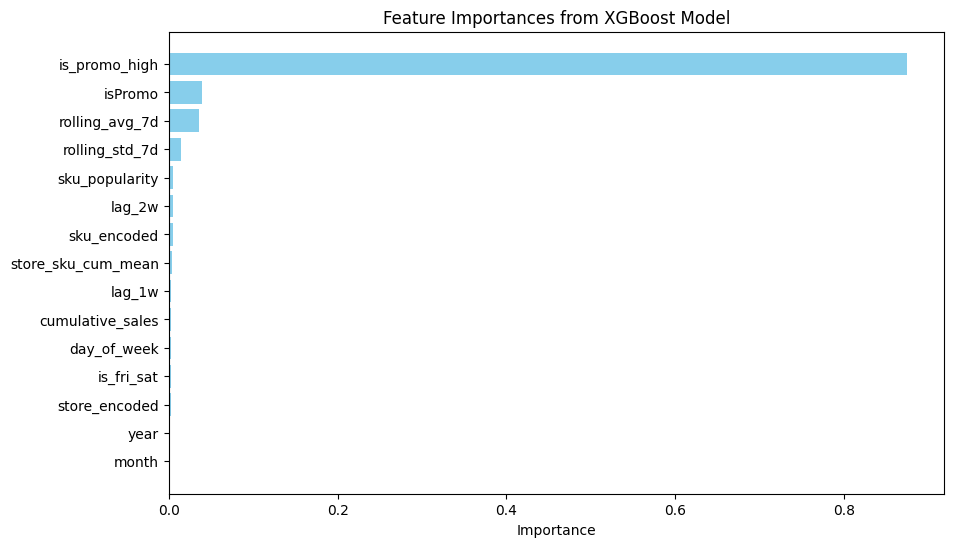

In [300]:
features = X.columns if isinstance(X, pd.DataFrame) else [f'Feature_{i}' for i in range(X_train.shape[1])]
feature_importances = xgb_final_model.feature_importances_

importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("Feature Importances (Descending Order):")
print(importance_df)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances from XGBoost Model')
plt.gca().invert_yaxis()
plt.show()

This feature importance distribution emphasizes the role of promotions in driving sales, with is_promo_high dominating the model's predictive power.

It might be beneficial to explore additional promotion-related features or fine-tune how promotions are defined to further enhance model accuracy.

Rolling and lagged features have moderate influence, indicating the importance of past sales patterns but suggesting the need for careful tuning.

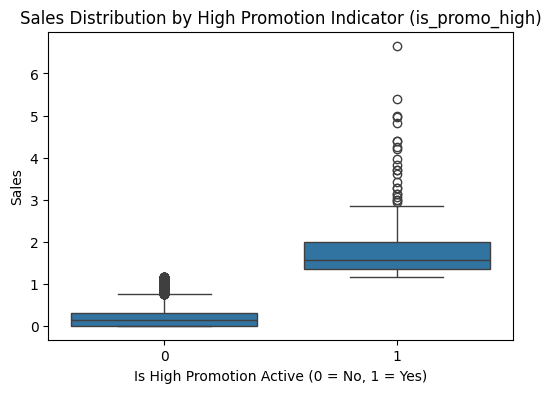

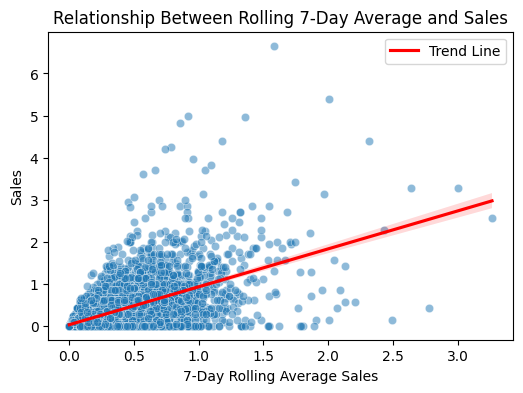

In [301]:
plt.figure(figsize=(6, 4))
sns.boxplot(data=df, x='is_promo_high', y='Sales')
plt.title('Sales Distribution by High Promotion Indicator (is_promo_high)')
plt.xlabel('Is High Promotion Active (0 = No, 1 = Yes)')
plt.ylabel('Sales')
plt.show()

plt.figure(figsize=(6, 4))
sns.scatterplot(data=df, x='rolling_avg_7d', y='Sales', alpha=0.5)
sns.regplot(data=df, x='rolling_avg_7d', y='Sales', scatter=False, color='red', label='Trend Line')
plt.title('Relationship Between Rolling 7-Day Average and Sales')
plt.xlabel('7-Day Rolling Average Sales')
plt.ylabel('Sales')
plt.legend()
plt.show()

Sales Distribution by High Promotion Indicator: This boxplot demonstrates a significant increase in sales during high promotion periods (is_promo_high = 1). The spread and median sales are substantially higher during these periods, confirming that promotions strongly drive sales.

Relationship Between Rolling 7-Day Average and Sales: This scatter plot with a fitted trend line suggests a positive correlation between the rolling 7-day average and sales. As expected, higher recent average sales are associated with increased sales for a given day. This trend indicates that recent sales history is a meaningful predictor of future sales.

In [302]:
warnings.filterwarnings("ignore")

def train_xgboost_by_store_sku(df, sku, store):
    df_filtered = df[(df['SKU'] == sku) & (df['Store'] == store)].copy()
    X = df_filtered.drop(['Sales', 'date', 'SKU', 'Store'], axis=1, errors='ignore')
    y = df_filtered['Sales']

    param_grid = {
        'n_estimators': [50, 100, 150],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2]
    }

    grid_search = GridSearchCV(XGBRegressor(objective='reg:squarederror', random_state=42), param_grid, scoring='neg_mean_absolute_error', cv=3)
    grid_search.fit(X, y)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X)
    mae = mean_absolute_error(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    feature_importance = best_model.feature_importances_
    importance_df = pd.DataFrame({'feature': X.columns, 'importance': feature_importance})

    print(f"\nOptimized XGBoost for {sku} at Store {store}:")
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")
    print(f"Feature Importance:\n{importance_df.sort_values(by='importance', ascending=False)}")

    return best_model, importance_df

def forecast_by_sku_store(df, sku, store, model, weeks_ahead=1):
    df_filtered = df[(df['SKU'] == sku) & (df['Store'] == store)].copy()
    last_week_data = df_filtered.tail(7).copy()
    last_week_data = last_week_data.select_dtypes(include=[np.number])
    input_features = last_week_data.mean().to_frame().T
    input_features = input_features.reindex(columns=model.feature_names_in_, fill_value=0)
    predictions = []
    start_date = df_filtered['date'].max() + timedelta(weeks=12)  # Three months ahead

    for week in range(weeks_ahead):
        pred_value = model.predict(input_features)[0]
        predictions.append((start_date + timedelta(weeks=week), pred_value))

        for lag in range(1, 7):
            input_features[f'lag_{lag}w'] = input_features.get(f'lag_{lag+1}w', pred_value)
        input_features[f'lag_7w'] = pred_value

    forecast_df = pd.DataFrame(predictions, columns=['date', 'predicted_sales'])
    forecast_df['SKU'] = sku
    forecast_df['Store'] = store

    return forecast_df

unique_combinations = df[['SKU', 'Store']].drop_duplicates()

results = []
feature_importances = []
for _, row in unique_combinations.iterrows():
    sku = row['SKU']
    store = row['Store']
    model, importance_df = train_xgboost_by_store_sku(df, sku, store)
    importance_df['SKU'] = sku
    importance_df['Store'] = store
    feature_importances.append(importance_df)
    forecast = forecast_by_sku_store(df, sku, store, model, weeks_ahead=1)
    results.append(forecast)

all_forecasts = pd.concat(results).reset_index(drop=True)
print("\nForecasts for All SKU-Store Combinations for the Next Week (3 months ahead):")
print(all_forecasts.head())

all_feature_importances = pd.concat(feature_importances).reset_index(drop=True)
print("\nFeature Importance for All SKU-Store Combinations:")
print(all_feature_importances.sort_values(by=['SKU', 'Store', 'importance'], ascending=[True, True, False]))


Optimized XGBoost for Baltika №0 Can at Store 3301:
Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 150}
MAE: 0.07, RMSE: 0.09
Feature Importance:
               feature  importance
5       rolling_avg_7d    0.309482
1          day_of_week    0.103862
2           is_fri_sat    0.097576
8   store_sku_cum_mean    0.085420
12    cumulative_sales    0.081803
0              isPromo    0.073596
11              lag_2w    0.067009
6       rolling_std_7d    0.065170
3                month    0.060372
10              lag_1w    0.055710
4                 year    0.000000
7        is_promo_high    0.000000
9       sku_popularity    0.000000
13       store_encoded    0.000000
14         sku_encoded    0.000000

Optimized XGBoost for Baltika №0 Can at Store 5941:
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
MAE: 0.06, RMSE: 0.08
Feature Importance:
               feature  importance
5       rolling_avg_7d    0.393272
2           is_fri_sat    

In [303]:
all_forecasts

,date,predicted_sales,SKU,Store
0,2017-09-06,0.160919,Baltika №0 Can,3301
1,2017-09-06,0.159077,Baltika №0 Can,5941
2,2017-09-06,0.213499,Don PET,3336
3,2017-09-06,0.039718,Baltika №3 Can,3301
4,2017-09-06,0.473593,Don PET,3301
5,2017-09-06,0.082595,Baltika №3 Can,3336
6,2017-09-06,0.199168,Baltika №9 Can,5941
7,2017-09-06,0.062513,Don PET,5941
8,2017-09-06,0.239861,Baltika №3 Can,5941
9,2017-09-06,0.135155,Baltika №7 Bottle,3301


Each row indicates a prediction of the total or representative sales for the entire upcoming week (starting on 2017-09-06) for that specific SKU-Store combination.

# Conclusion

### **Model Selection**
**Approach to Model Selection:**
The goal was to forecast weekly sales for each SKU-Store combination. The initial step involved evaluating different models for overall sales prediction accuracy. This approach provided insight into model performance across various SKUs and stores, leading to the selection of the model most suited for detailed SKU-Store-specific sales forecasting.

**Optimized XGBoost as the Model of Choice:**
XGBoost was the top-performing model after optimization, achieving consistent low error metrics:

- Optimized XGBoost Performance: MAE of 0.13 and RMSE of 0.19.
- This demonstrated XGBoost's ability to accurately capture sales trends, making it the ideal choice for SKU-Store-level forecasts.
- This outperformed other models such as Random Forest and LSTM.

### **Understanding MAE and RMSE for Sales Forecasting**

**Why MAE and RMSE?:**

- MAE provides an average of the absolute errors, directly indicating the typical deviation between predicted and actual sales.

- RMSE emphasizes larger errors due to its squared term, making it valuable for highlighting significant sales fluctuations that could impact inventory, promotions, or store operations.

### **SKU-Store-Specific Weekly Sales Forecasting**

- Product: Baltika №0 Can:
> - Store: 3301
>> - MAE: 0.07
>> - RMSE: 0.09
>> - Key Insight: Sales at Store 3301 are relatively stable, as indicated by low error values.
>> - **Forecasted Weekly Sales: 0.1609**
> - Store: 5941
>> - MAE: 0.06
>> - RMSE: 0.08
>> - Key Insight: Sales at Store 5941 show a slightly lower error margin, suggesting stable sales patterns with minor variability.
>> - **Forecasted Weekly Sales: 0.1591**
> - Store: 3336
>> - MAE: 0.10
>> - RMSE: 0.13
>> - Key Insight: Moderate variability in sales is captured at Store 3336.
>> - **Forecasted Weekly Sales: 0.1384**

- Product: Don PET
> - Store: 3336
>> - MAE: 0.17
>> - RMSE: 0.21
>> - Key Insight: Sales at Store 3336 have higher variability, as reflected by the relatively higher error values.
>> - **Forecasted Weekly Sales: 0.2135**
> - Store: 3301
>> - MAE: 0.17
>> - RMSE: 0.21
>> - Key Insight: Sales variability is evident at Store 3301, as seen from the relatively high error margins.
>> - **Forecasted Weekly Sales: 0.4736**
> - Store: 5941
>> - MAE: 0.13
>> - RMSE: 0.16
>> - Key Insight: Sales for Don PET at Store 5941 demonstrate moderate variability.
>> - **Forecasted Weekly Sales: 0.0625**

- Product: Baltika №3 Can
> - Store: 3301
>> - MAE: 0.03
>> - RMSE: 0.05
>> - Key Insight: Sales at Store 3301 for this product are highly predictable with minimal error, indicating consistent sales patterns.
>> - **Forecasted Weekly Sales: 0.0397**
> - Store: 3336
>> - MAE: 0.11
>> - RMSE: 0.13
>> - Key Insight: Moderate sales variability is observed at Store 3336 for this SKU.
>> - **Forecasted Weekly Sales: 0.0826**
> - Store: 5941
>> - MAE: 0.13
>> - RMSE: 0.18
>> - Key Insight: Sales patterns at Store 5941 indicate a somewhat higher level of variability for this SKU.
>> - **Forecasted Weekly Sales: 0.2399**

- Product: Baltika №9 Can
> - Store: 5941
>> - MAE: 0.09
>> - RMSE: 0.12
>> - Key Insight: Sales at Store 5941 for this product exhibit some variability, though relatively consistent compared to other SKUs.
>> - **Forecasted Weekly Sales: 0.1992**
> - Store: 3301
>> - MAE: 0.06
>> - RMSE: 0.08
>> - Key Insight: Sales patterns at Store 3301 are highly predictable with minimal error.
>> - **Forecasted Weekly Sales: 0.3046**
> - Store: 3336
>> - MAE: 0.06
>> - RMSE: 0.08
>> - Key Insight: Sales are relatively stable at Store 3336 for this SKU.
>> - **Forecasted Weekly Sales: 0.0867**

- Product: Baltika №7 Bottle
> - Store: 3301
>> - MAE: 0.14
>> - RMSE: 0.20
>> - Key Insight: Sales at Store 3301 for this SKU show moderate variability.
>> - **Forecasted Weekly Sales: 0.1352**
> - Store: 3336
>> - MAE: 0.04
>> - RMSE: 0.06
>> - Key Insight: Very stable sales patterns at Store 3336 for this SKU.
>> - **Forecasted Weekly Sales: 0.0538**
> - Store: 5941
>> - MAE: 0.09
>> - RMSE: 0.13
>> - Key Insight: Sales variability is present, but the model captures most of the patterns accurately.
>> - **Forecasted Weekly Sales: 0.0211**

- Product: Baltika №7 Can
> - Store: 5941
>> - MAE: 0.09
>> - RMSE: 0.12
>> - Key Insight: Sales at Store 5941 are moderately predictable.
>> - **Forecasted Weekly Sales: 0.1215**
> - Store: 3301
>> - MAE: 0.14
>> - RMSE: 0.18
>> - Key Insight: Moderate sales variability is noted at Store 3301.
>> - **Forecasted Weekly Sales: 0.1330**
> - Store: 3336
>> - MAE: 0.11
>> - RMSE: 0.15
>> - Key Insight: Sales variability is moderate at Store 3336 for this SKU.
>> - **Forecasted Weekly Sales: 0.1028**

**Error Analysis**

- Across SKU-Store combinations, MAE values were generally low, indicating accurate sales predictions.

- RMSE values highlighted sales variability, with certain combinations like Don PET at Store 3336 exhibiting more pronounced fluctuations due to promotions or external factors.

### **Feature Importance Analysis**

XGBoost's feature importance analysis revealed key drivers of sales predictions. Common influential features included:

- Rolling average sales: Captured recent sales trends effectively.

- Is promo high: Significant for identifying spikes in sales during promotions.

- Lagged sales features: Important for understanding historical sales patterns.